In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('default')
import yfinance as yf
from datetime import datetime

In [2]:
# Define the ticker symbol
ticker_symbol = 'BMRI.JK'

# Fetch the data
bmri_data = yf.download(ticker_symbol, start='2019-03-11', end='2024-03-11')
bmri_data

[*********************100%%**********************]  1 of 1 completed


Open    High     Low   Close    Adj Close     Volume
Date                                                              
2019-03-11  3475.0  3475.0  3412.5  3425.0  2638.515137   53912400
2019-03-12  3412.5  3437.5  3337.5  3362.5  2590.367188   60509600
2019-03-13  3400.0  3400.0  3325.0  3350.0  2580.737793   55730600
2019-03-14  3400.0  3462.5  3362.5  3450.0  2657.774658   44212200
2019-03-15  3462.5  3550.0  3462.5  3550.0  2734.811279   71744400
...            ...     ...     ...     ...          ...        ...
2024-03-04  7000.0  7050.0  6975.0  7025.0  6683.206055   44707200
2024-03-05  7075.0  7100.0  7000.0  7025.0  6683.206055   92557200
2024-03-06  7000.0  7100.0  7000.0  7075.0  6730.773438   74178100
2024-03-07  7075.0  7125.0  7025.0  7100.0  6754.556641   94950400
2024-03-08  7150.0  7175.0  7100.0  7125.0  6778.340332  109032400

[1229 rows x 6 columns]

In [5]:
# drop 0 value in Volume
bmri_data = bmri_data[bmri_data.Volume != 0]

#Data telah bersih
a = bmri_data[bmri_data.Volume == 0]
len(a)

bmri_data

Open    High     Low   Close    Adj Close     Volume
Date                                                              
2019-03-11  3475.0  3475.0  3412.5  3425.0  2638.515137   53912400
2019-03-12  3412.5  3437.5  3337.5  3362.5  2590.367188   60509600
2019-03-13  3400.0  3400.0  3325.0  3350.0  2580.737793   55730600
2019-03-14  3400.0  3462.5  3362.5  3450.0  2657.774658   44212200
2019-03-15  3462.5  3550.0  3462.5  3550.0  2734.811279   71744400
...            ...     ...     ...     ...          ...        ...
2024-03-04  7000.0  7050.0  6975.0  7025.0  6683.206055   44707200
2024-03-05  7075.0  7100.0  7000.0  7025.0  6683.206055   92557200
2024-03-06  7000.0  7100.0  7000.0  7075.0  6730.773438   74178100
2024-03-07  7075.0  7125.0  7025.0  7100.0  6754.556641   94950400
2024-03-08  7150.0  7175.0  7100.0  7125.0  6778.340332  109032400

[1218 rows x 6 columns]

In [6]:
# Create a new dataframe with only the Close column 
data = bmri_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.90) # 90% 10%

# Split dataset into training and testing sets
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

# Normalize data
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_train_data

array([[0.36910377],
       [0.35436321],
       [0.35141509],
       ...,
       [0.95283019],
       [0.95872642],
       [0.94693396]])

In [7]:
print(scaled_train_data.shape)
print(len(scaled_train_data))

(1097, 1)
1097


In [8]:
from keras.layers import Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
# Function to train LSTM model and return predictions and RMSE
def train_lstm_model(x_train, y_train, x_test, actual):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(LSTM(50, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(Dense(25, activation='linear'))  # Adding a linear activation function
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, actual),
              callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1, mode='min')], verbose= 1, shuffle=False)

    # Get the models predicted price values from train
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions) # unscaling the values

    # Get the root mean squared error (RMSE)
    rmse= np.sqrt(np.mean(((predictions - actual)**2)))
    mape= np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return predictions, rmse, mape

In [9]:
# Create empty lists to store results
all_predictions = []
all_rmse = []
all_mape = []

# Perform 50 runs of LSTM
for i in range(50):
    print(f"Run: {i+1}")
    # Create the scaled training data set with window size = 100
    train_data = scaled_train_data
    #split the data into x_train and y_train dataset
    x_train = []
    y_train = []
    for i in range(100, len(train_data)):
        x_train.append(train_data[i-100:i])
        y_train.append(train_data[i])
    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    print(len(x_train))
    print(len(y_train))
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the scaled testing data set
    testing_data = dataset[training_data_len-100:]
    test_data = scaler.transform(testing_data.reshape(-1,1))
    # Create the dataset x_test and y_test
    x_test = []
    for i in range(100, len(test_data)):
        x_test.append(test_data[i-100:i])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    actual = dataset[training_data_len:]
    # Train LSTM model and return predictions, RMSE, and MAPE
    predictions, rmse, mape = train_lstm_model(x_train, y_train, x_test, actual)
    
    # Append predictions and RMSE to lists
    all_predictions.append(predictions)
    all_rmse.append(rmse)
    all_mape.append(mape)

Run: 1
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0438 - val_loss: 39489044.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0075 - val_loss: 39488600.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0084 - val_loss: 39488836.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0097 - val_loss: 39488060.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0160 - val_loss: 39486792.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0365 - val_loss: 39488112.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0335 - val_loss: 39487836.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0582 - val_loss: 39489224.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0319 - val_loss: 39486748.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0046 - val_loss: 39487820.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017 - val_loss: 39487856.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0502 - val_loss: 39489176.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0070 - val_loss: 39488496.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0089 - val_loss: 39487692.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0170 - val_loss: 39488304.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0183 - val_loss: 39487248.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0324 - val_loss: 39486136.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0547 - val_loss: 39486856.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0539 - val_loss: 39488760.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0297 - val_loss: 39487208.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050 - val_loss: 39487984.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 39487952.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0441 - val_loss: 39489008.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - val_loss: 39488672.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0095 - val_loss: 39488204.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0146 - val_loss: 39487100.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0243 - val_loss: 39486948.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0350 - val_loss: 39486764.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0522 - val_loss: 39487632.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0432 - val_loss: 39487740.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0177 - val_loss: 39487312.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026 - val_loss: 39488032.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0018 - val_loss: 39487776.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0645 - val_loss: 39488424.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0095 - val_loss: 39488256.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0153 - val_loss: 39486296.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0432 - val_loss: 39486520.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0427 - val_loss: 39488940.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0463 - val_loss: 39488168.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0209 - val_loss: 39487336.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 39487880.0000
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 5
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0660 - val_loss: 39489088.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0106 - val_loss: 39488400.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0112 - val_loss: 39487328.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0220 - val_loss: 39486372.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0337 - val_loss: 39486336.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0414 - val_loss: 39487912.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0400 - val_loss: 39487368.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0205 - val_loss: 39486912.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0045 - val_loss: 39487692.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 39487712.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 6
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0421 - val_loss: 39488848.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0051 - val_loss: 39488624.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0079 - val_loss: 39488456.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115 - val_loss: 39488168.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0167 - val_loss: 39488328.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0214 - val_loss: 39486964.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0443 - val_loss: 39486840.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0627 - val_loss: 39488468.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0395 - val_loss: 39487496.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0127 - val_loss: 39487472.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 39488092.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0424 - val_loss: 39488768.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0072 - val_loss: 39488680.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0068 - val_loss: 39488556.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0095 - val_loss: 39487860.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0192 - val_loss: 39488024.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0257 - val_loss: 39487168.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0397 - val_loss: 39486600.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0633 - val_loss: 39489000.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0461 - val_loss: 39488476.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0161 - val_loss: 39487232.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 39488172.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0345 - val_loss: 39488972.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0069 - val_loss: 39488912.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0069 - val_loss: 39488844.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0095 - val_loss: 39487812.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0207 - val_loss: 39487336.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0295 - val_loss: 39487848.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0330 - val_loss: 39486288.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0632 - val_loss: 39489444.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0376 - val_loss: 39487708.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0168 - val_loss: 39487604.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 39488276.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0481 - val_loss: 39489180.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0063 - val_loss: 39488408.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0148 - val_loss: 39487104.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0303 - val_loss: 39487500.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0317 - val_loss: 39487600.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0564 - val_loss: 39488240.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0389 - val_loss: 39487824.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0152 - val_loss: 39487328.0000
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 10
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0438 - val_loss: 39489248.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0062 - val_loss: 39488652.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0085 - val_loss: 39487804.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0203 - val_loss: 39487520.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0254 - val_loss: 39487572.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0359 - val_loss: 39487548.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0568 - val_loss: 39488276.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0375 - val_loss: 39487440.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0145 - val_loss: 39487672.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 39488024.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 39488028.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0845 - val_loss: 39489096.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0077 - val_loss: 39488664.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0141 - val_loss: 39486724.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0281 - val_loss: 39485968.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0496 - val_loss: 39487456.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0430 - val_loss: 39487784.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0214 - val_loss: 39486956.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0035 - val_loss: 39487800.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 39487980.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 12
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0352 - val_loss: 39489172.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0054 - val_loss: 39488596.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0062 - val_loss: 39488656.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0100 - val_loss: 39488412.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0139 - val_loss: 39487892.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0204 - val_loss: 39488012.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0284 - val_loss: 39486656.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0592 - val_loss: 39487572.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0523 - val_loss: 39488372.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0266 - val_loss: 39487368.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 39487960.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0463 - val_loss: 39488928.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0076 - val_loss: 39488480.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0094 - val_loss: 39487920.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0149 - val_loss: 39486624.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0271 - val_loss: 39486984.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0259 - val_loss: 39486668.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0389 - val_loss: 39488284.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0376 - val_loss: 39486920.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0158 - val_loss: 39487276.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 14
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0307 - val_loss: 39488768.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0075 - val_loss: 39488720.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0059 - val_loss: 39488792.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 39488496.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0095 - val_loss: 39488780.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0103 - val_loss: 39487920.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0177 - val_loss: 39486584.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0381 - val_loss: 39486524.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0568 - val_loss: 39487696.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0411 - val_loss: 39487592.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0163 - val_loss: 39487200.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0341 - val_loss: 39488508.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0077 - val_loss: 39488964.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0069 - val_loss: 39488444.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0096 - val_loss: 39487880.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0169 - val_loss: 39488992.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0183 - val_loss: 39486888.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0355 - val_loss: 39486208.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0483 - val_loss: 39487040.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0570 - val_loss: 39488844.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0319 - val_loss: 39487356.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071 - val_loss: 39487904.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0416 - val_loss: 39488736.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0074 - val_loss: 39488668.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0074 - val_loss: 39488356.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115 - val_loss: 39487352.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0243 - val_loss: 39488808.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0196 - val_loss: 39486428.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0466 - val_loss: 39486888.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0395 - val_loss: 39487344.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0306 - val_loss: 39487232.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - val_loss: 39487488.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 39488304.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0401 - val_loss: 39488240.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0071 - val_loss: 39488584.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0055 - val_loss: 39488632.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0095 - val_loss: 39488588.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0121 - val_loss: 39488612.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0212 - val_loss: 39486632.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0379 - val_loss: 39486836.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0495 - val_loss: 39487208.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0480 - val_loss: 39488272.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0250 - val_loss: 39487056.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - val_loss: 39487944.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0511 - val_loss: 39488872.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 39488396.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - val_loss: 39487160.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0261 - val_loss: 39487752.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0262 - val_loss: 39486592.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0597 - val_loss: 39488676.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0456 - val_loss: 39488440.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0202 - val_loss: 39487164.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 39488004.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - val_loss: 39488020.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 19
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0446 - val_loss: 39488796.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0069 - val_loss: 39488648.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 39487896.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0191 - val_loss: 39486604.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0416 - val_loss: 39487028.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0360 - val_loss: 39486524.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0519 - val_loss: 39488600.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0336 - val_loss: 39487592.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0094 - val_loss: 39487792.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 39488028.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 39487652.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0567 - val_loss: 39489100.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0080 - val_loss: 39488604.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0120 - val_loss: 39487232.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0296 - val_loss: 39486944.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0383 - val_loss: 39486776.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0648 - val_loss: 39488796.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0438 - val_loss: 39488264.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0186 - val_loss: 39487124.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 39488232.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 39487476.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 21
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0420 - val_loss: 39488808.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 39487864.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0084 - val_loss: 39488496.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - val_loss: 39487928.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0151 - val_loss: 39487568.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0228 - val_loss: 39487908.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0279 - val_loss: 39487056.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0492 - val_loss: 39486892.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0432 - val_loss: 39487628.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0284 - val_loss: 39486968.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0047 - val_loss: 39487704.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0440 - val_loss: 39488856.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071 - val_loss: 39488688.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - val_loss: 39488928.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0083 - val_loss: 39488196.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0163 - val_loss: 39486688.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0352 - val_loss: 39486464.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0385 - val_loss: 39486784.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0611 - val_loss: 39488616.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0352 - val_loss: 39487720.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0099 - val_loss: 39487736.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 39488024.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0366 - val_loss: 39489408.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058 - val_loss: 39488168.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - val_loss: 39488968.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0103 - val_loss: 39488120.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0189 - val_loss: 39487440.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0350 - val_loss: 39485920.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0673 - val_loss: 39488504.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0522 - val_loss: 39489216.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0267 - val_loss: 39487648.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 39487988.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 39488216.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0479 - val_loss: 39489064.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0064 - val_loss: 39488960.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 39488596.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0133 - val_loss: 39487728.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0241 - val_loss: 39487076.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0401 - val_loss: 39487104.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0567 - val_loss: 39487580.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0400 - val_loss: 39487592.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0189 - val_loss: 39487344.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 39488136.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 25
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0741 - val_loss: 39488664.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0116 - val_loss: 39489072.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0098 - val_loss: 39487504.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0212 - val_loss: 39486272.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0329 - val_loss: 39486896.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0375 - val_loss: 39487868.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0439 - val_loss: 39487780.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0210 - val_loss: 39487112.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - val_loss: 39488024.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 26
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0533 - val_loss: 39488856.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0066 - val_loss: 39488724.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0110 - val_loss: 39487544.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0223 - val_loss: 39485740.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0465 - val_loss: 39486024.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0529 - val_loss: 39488488.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0408 - val_loss: 39487800.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0185 - val_loss: 39487068.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 39487884.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 27
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0400 - val_loss: 39488976.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0074 - val_loss: 39488692.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0070 - val_loss: 39488260.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0122 - val_loss: 39486920.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0241 - val_loss: 39488168.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0245 - val_loss: 39487232.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0490 - val_loss: 39487360.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0440 - val_loss: 39487936.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0272 - val_loss: 39486916.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0080 - val_loss: 39487608.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 39487992.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0663 - val_loss: 39488776.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0076 - val_loss: 39488804.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0081 - val_loss: 39488588.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0083 - val_loss: 39488544.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0119 - val_loss: 39487868.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0242 - val_loss: 39486660.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0429 - val_loss: 39486640.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0611 - val_loss: 39488012.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0428 - val_loss: 39487516.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0188 - val_loss: 39487312.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 39487956.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0460 - val_loss: 39489000.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0064 - val_loss: 39488324.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 39488632.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0127 - val_loss: 39486648.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0397 - val_loss: 39487204.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0346 - val_loss: 39487816.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0556 - val_loss: 39488324.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0341 - val_loss: 39487348.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0093 - val_loss: 39487616.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 30
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0358 - val_loss: 39489020.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0070 - val_loss: 39488648.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0061 - val_loss: 39488660.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0102 - val_loss: 39487816.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0223 - val_loss: 39486812.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0409 - val_loss: 39487272.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0398 - val_loss: 39487864.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0585 - val_loss: 39489144.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0341 - val_loss: 39487416.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0108 - val_loss: 39487864.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 31
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0382 - val_loss: 39488872.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0049 - val_loss: 39488380.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075 - val_loss: 39488536.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0101 - val_loss: 39488224.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0152 - val_loss: 39488436.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0203 - val_loss: 39486808.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0440 - val_loss: 39486368.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0586 - val_loss: 39487784.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0500 - val_loss: 39488200.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0237 - val_loss: 39487152.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 39487956.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0317 - val_loss: 39488876.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 39488392.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0074 - val_loss: 39488736.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0081 - val_loss: 39488740.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0090 - val_loss: 39487692.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0215 - val_loss: 39488128.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0267 - val_loss: 39487336.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0357 - val_loss: 39486052.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0507 - val_loss: 39488948.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0547 - val_loss: 39488404.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0228 - val_loss: 39487240.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0667 - val_loss: 39488788.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0090 - val_loss: 39488992.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088 - val_loss: 39487792.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0202 - val_loss: 39487180.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0299 - val_loss: 39485968.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0568 - val_loss: 39487264.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0527 - val_loss: 39488576.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0275 - val_loss: 39487356.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0046 - val_loss: 39487984.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0025 - val_loss: 39488104.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Run: 34
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0500 - val_loss: 39488972.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0063 - val_loss: 39488260.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0097 - val_loss: 39487820.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0171 - val_loss: 39486616.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0323 - val_loss: 39486996.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0314 - val_loss: 39487872.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0538 - val_loss: 39487892.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0319 - val_loss: 39487052.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0099 - val_loss: 39487588.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 35
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0555 - val_loss: 39488928.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0066 - val_loss: 39488688.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0099 - val_loss: 39487512.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0234 - val_loss: 39486284.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0434 - val_loss: 39486832.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0455 - val_loss: 39487848.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0493 - val_loss: 39488076.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0189 - val_loss: 39487248.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 39487872.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 36
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0493 - val_loss: 39489484.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0056 - val_loss: 39488916.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0090 - val_loss: 39488328.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0188 - val_loss: 39487160.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0348 - val_loss: 39486816.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0464 - val_loss: 39488904.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0518 - val_loss: 39489124.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0260 - val_loss: 39487336.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 39488144.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031 - val_loss: 39488016.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 37
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0259 - val_loss: 39488216.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 39488376.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0052 - val_loss: 39488560.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 39488444.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0060 - val_loss: 39488808.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0063 - val_loss: 39488444.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 38
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0697 - val_loss: 39488540.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 39488396.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0137 - val_loss: 39487768.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0229 - val_loss: 39486852.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0394 - val_loss: 39487036.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0566 - val_loss: 39487576.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0458 - val_loss: 39487412.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0178 - val_loss: 39487400.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 39488112.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 39
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0333 - val_loss: 39489056.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0067 - val_loss: 39488456.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0097 - val_loss: 39488468.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0121 - val_loss: 39487888.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0193 - val_loss: 39487424.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0344 - val_loss: 39486564.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0502 - val_loss: 39488560.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0508 - val_loss: 39488984.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0234 - val_loss: 39487236.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 39488100.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 39488008.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0527 - val_loss: 39488736.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0057 - val_loss: 39488540.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0099 - val_loss: 39487916.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0138 - val_loss: 39487004.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0265 - val_loss: 39487052.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0314 - val_loss: 39486864.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0515 - val_loss: 39486992.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0426 - val_loss: 39488204.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0220 - val_loss: 39487292.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 39488112.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 39487892.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0368 - val_loss: 39489168.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0050 - val_loss: 39488036.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0070 - val_loss: 39488960.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0053 - val_loss: 39488416.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0114 - val_loss: 39488408.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0149 - val_loss: 39487176.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0319 - val_loss: 39487816.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0357 - val_loss: 39486544.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0471 - val_loss: 39487996.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0488 - val_loss: 39487916.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0272 - val_loss: 39487000.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0532 - val_loss: 39488996.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - val_loss: 39488408.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0143 - val_loss: 39486992.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0333 - val_loss: 39487712.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0309 - val_loss: 39487144.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0634 - val_loss: 39489008.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0399 - val_loss: 39487304.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0142 - val_loss: 39487424.0000
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 43
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0539 - val_loss: 39489112.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058 - val_loss: 39488536.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088 - val_loss: 39487640.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0196 - val_loss: 39486516.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0374 - val_loss: 39486900.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0337 - val_loss: 39487192.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0512 - val_loss: 39487400.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0357 - val_loss: 39487456.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0123 - val_loss: 39487416.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 44
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0864 - val_loss: 39488796.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0124 - val_loss: 39488264.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0186 - val_loss: 39486168.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0483 - val_loss: 39486276.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0538 - val_loss: 39487552.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0333 - val_loss: 39487216.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0128 - val_loss: 39487244.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022 - val_loss: 39487840.0000
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run: 45
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0533 - val_loss: 39489024.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0066 - val_loss: 39488592.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - val_loss: 39487324.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0245 - val_loss: 39487120.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0322 - val_loss: 39486936.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0470 - val_loss: 39487492.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0486 - val_loss: 39487888.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0297 - val_loss: 39487200.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0083 - val_loss: 39487808.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 39488176.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 46
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0437 - val_loss: 39488784.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0064 - val_loss: 39488688.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0084 - val_loss: 39488148.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0138 - val_loss: 39487168.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0230 - val_loss: 39486784.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0354 - val_loss: 39486224.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0483 - val_loss: 39487184.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0435 - val_loss: 39488700.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0234 - val_loss: 39487356.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 39488000.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 39487996.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0484 - val_loss: 39489104.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0074 - val_loss: 39488056.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0102 - val_loss: 39487916.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0165 - val_loss: 39486984.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0279 - val_loss: 39487320.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0362 - val_loss: 39487332.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0577 - val_loss: 39489152.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0358 - val_loss: 39487876.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0126 - val_loss: 39487640.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 48
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0649 - val_loss: 39489232.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0106 - val_loss: 39488668.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0125 - val_loss: 39487008.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0332 - val_loss: 39485872.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0498 - val_loss: 39487368.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0467 - val_loss: 39488672.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0269 - val_loss: 39487232.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0056 - val_loss: 39487756.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 39488056.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 49
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0505 - val_loss: 39488904.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0076 - val_loss: 39488500.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0157 - val_loss: 39487484.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0273 - val_loss: 39487004.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0353 - val_loss: 39486496.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0455 - val_loss: 39488528.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0500 - val_loss: 39488676.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0234 - val_loss: 39487320.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0040 - val_loss: 39487880.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 39487996.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 50
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0457 - val_loss: 39488980.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0051 - val_loss: 39488608.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0080 - val_loss: 39488508.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0114 - val_loss: 39486616.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0317 - val_loss: 39488012.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0279 - val_loss: 39486464.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0432 - val_loss: 39487616.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0528 - val_loss: 39487960.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0238 - val_loss: 39486960.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 39488008.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 39487840.00

In [10]:
# Create DataFrame to store results
results_df = pd.DataFrame()

# Add predictions to DataFrame
for i in range(50):
    col_name = f'Prediction_{i+1}'
    predictions_series = pd.Series(all_predictions[i].reshape(-1), name=col_name)
    results_df = pd.concat([results_df, predictions_series], axis=1)

# Add RMSE & MAPE as a row to DataFrame if the lengths match
results_df.loc['RMSE'] = all_rmse
results_df.loc['MAPE'] = all_mape

# Calculate average of predictions from Prediction_1 to Prediction_50
results_df['Average_Prediction'] = results_df.iloc[:, :].mean(axis=1)

# Calculate standard deviation of predictions from Prediction_1 to Prediction_50
results_df['Prediction_Std'] = results_df.iloc[:, :-1].std(axis=1)

# Print results DataFrame
print(results_df)

      Prediction_1  Prediction_2  Prediction_3  Prediction_4  Prediction_5  \
0      5987.244629   5905.916992   5955.459961   5938.686523   5978.980469   
1      5968.399414   5888.783203   5937.041504   5921.822754   5963.144043   
2      5947.335449   5869.892578   5916.774902   5903.237305   5945.312988   
3      5933.347168   5859.495117   5904.962891   5892.170898   5935.034668   
4      5923.103516   5851.999512   5896.707520   5884.448730   5927.391113   
...            ...           ...           ...           ...           ...   
118    6878.402832   6771.890137   6858.997070   6769.787598   6891.810547   
119    6872.119629   6768.308594   6854.619141   6765.756348   6888.955078   
120    6870.444824   6768.903809   6854.800781   6765.944824   6889.878418   
RMSE    184.072395    234.528340    193.540483    225.129437    186.748221   
MAPE      2.192197      2.875187      2.316757      2.667725      2.221386   

      Prediction_6  Prediction_7  Prediction_8  Prediction_9  P

In [11]:
# Save DataFrame to CSV with header
results_df.to_csv('BMRILSTMFullW100.csv', header=True)

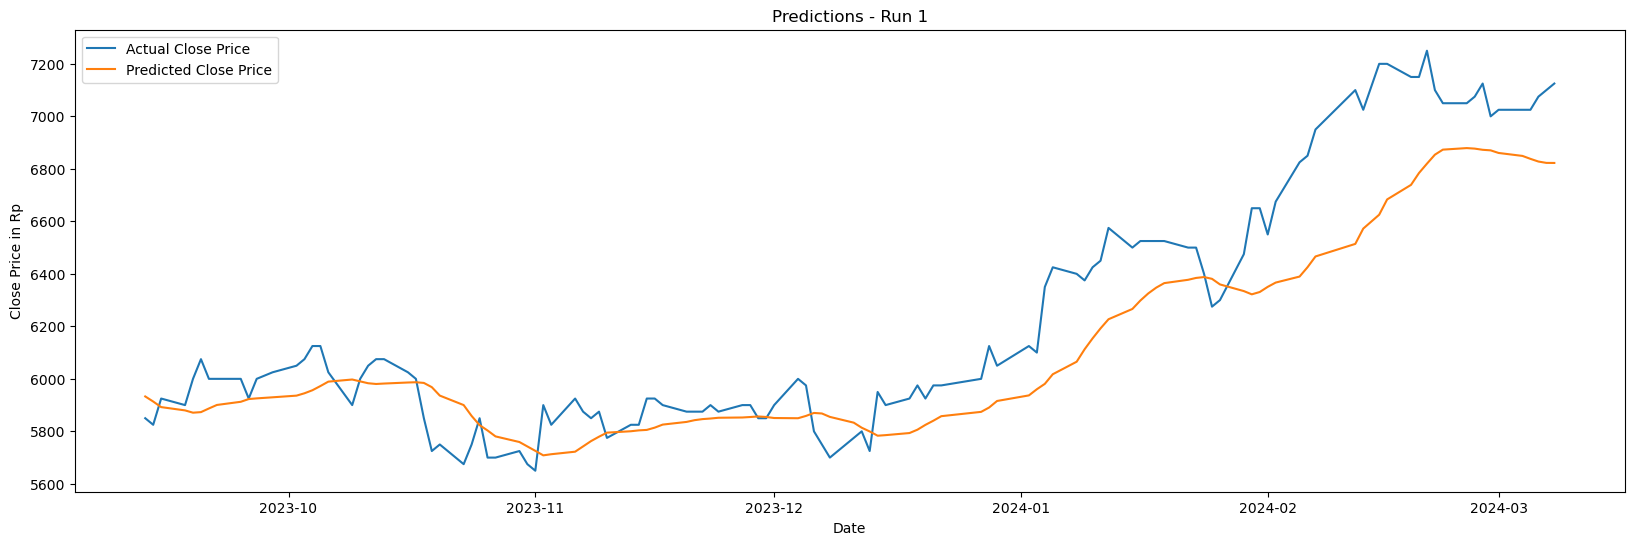

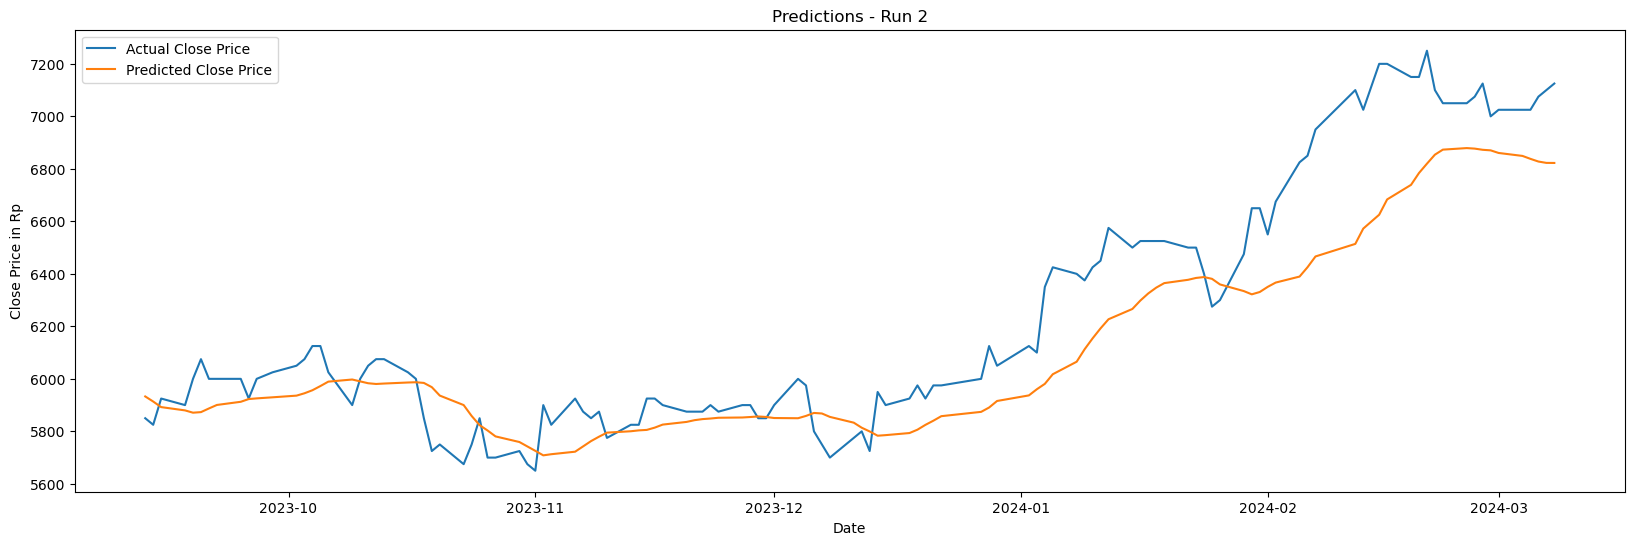

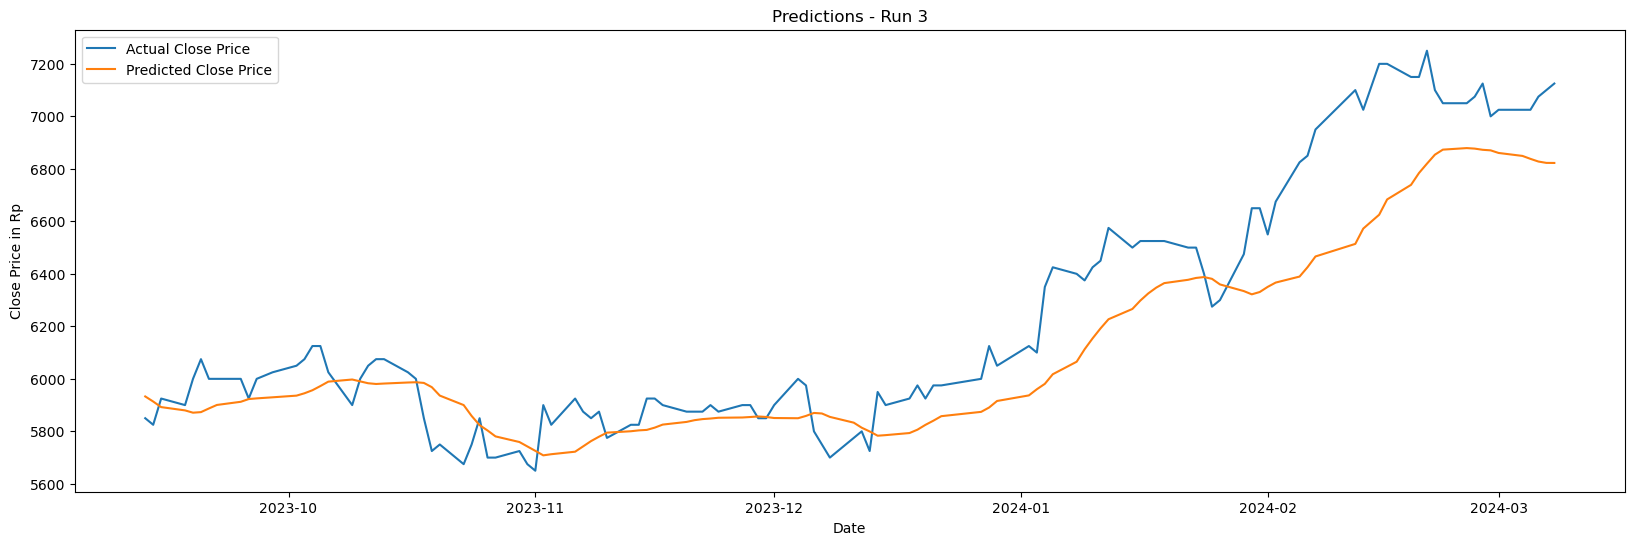

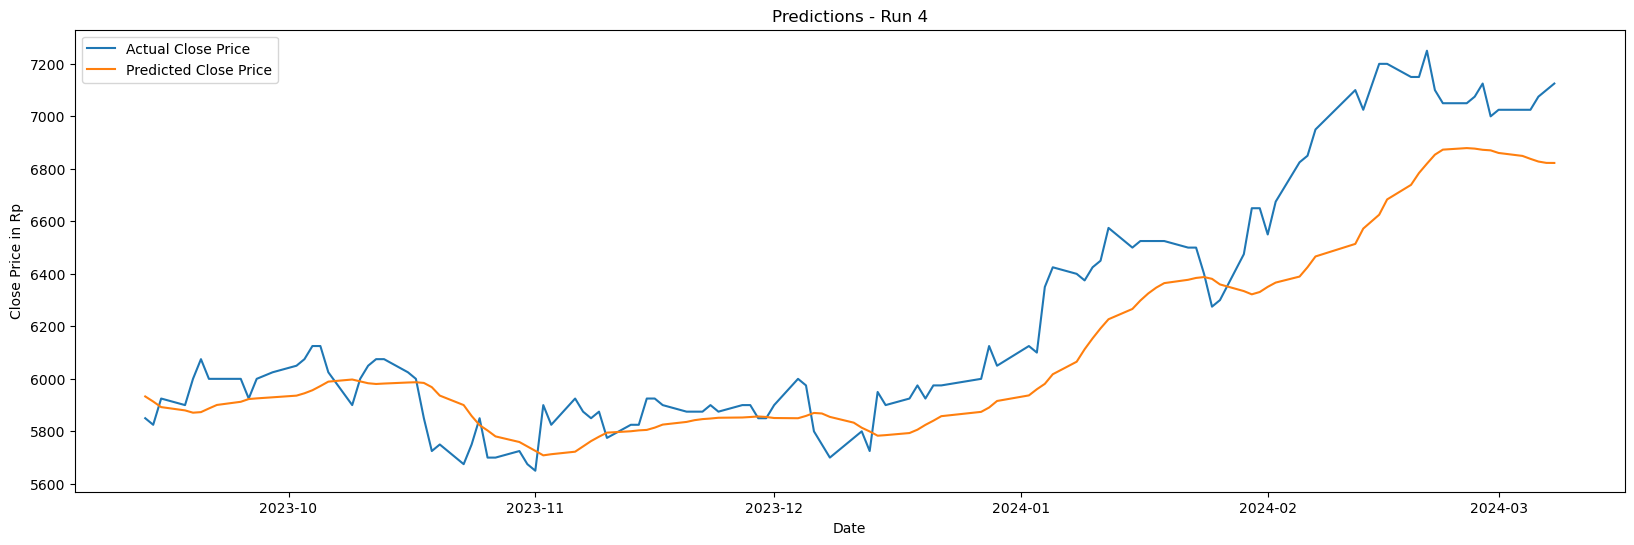

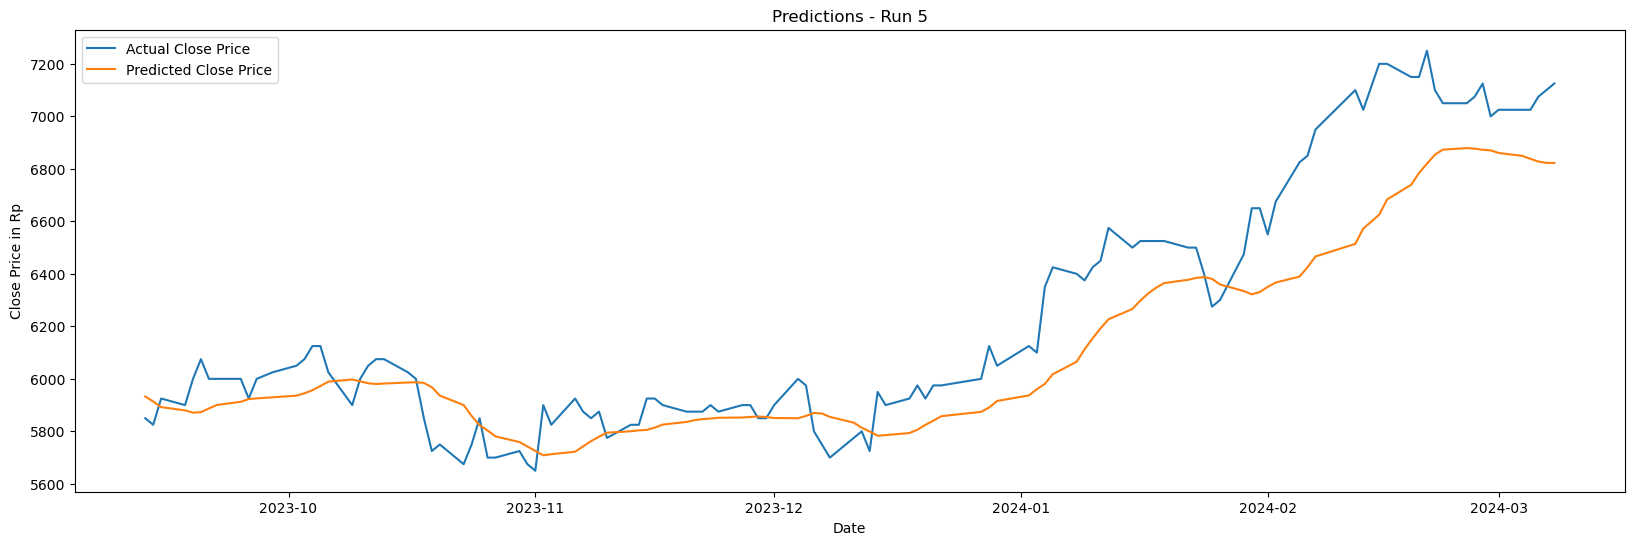

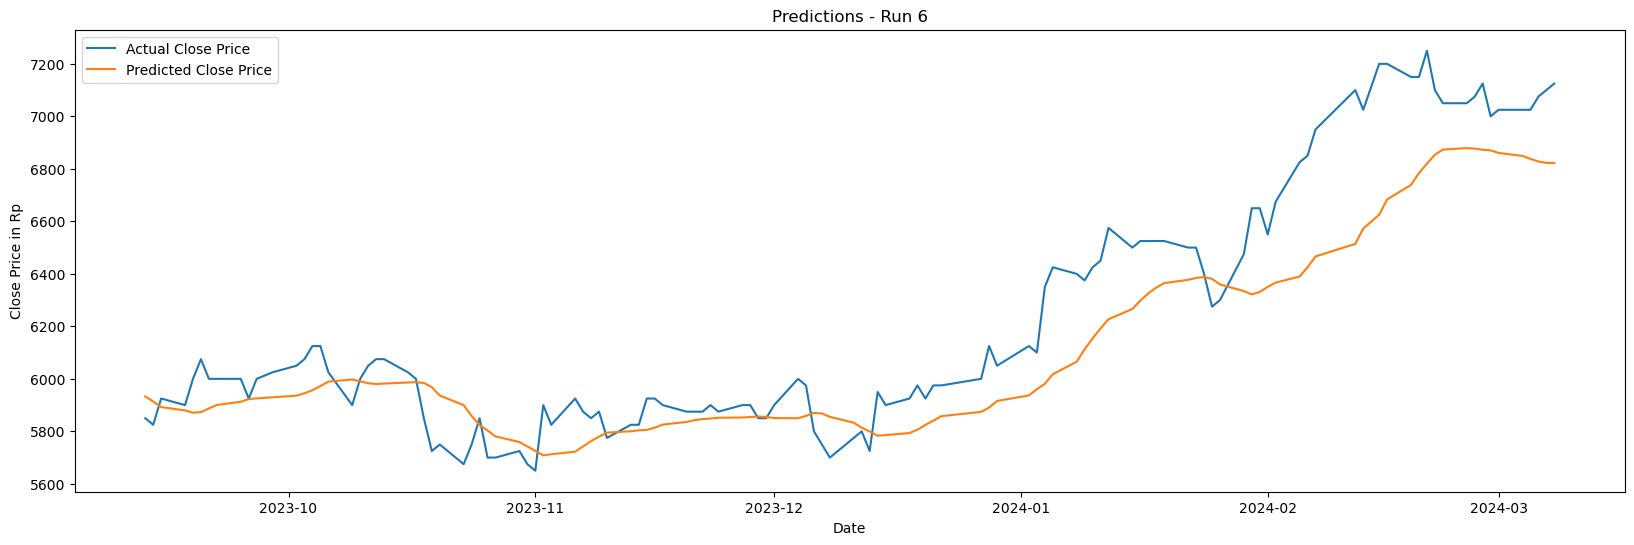

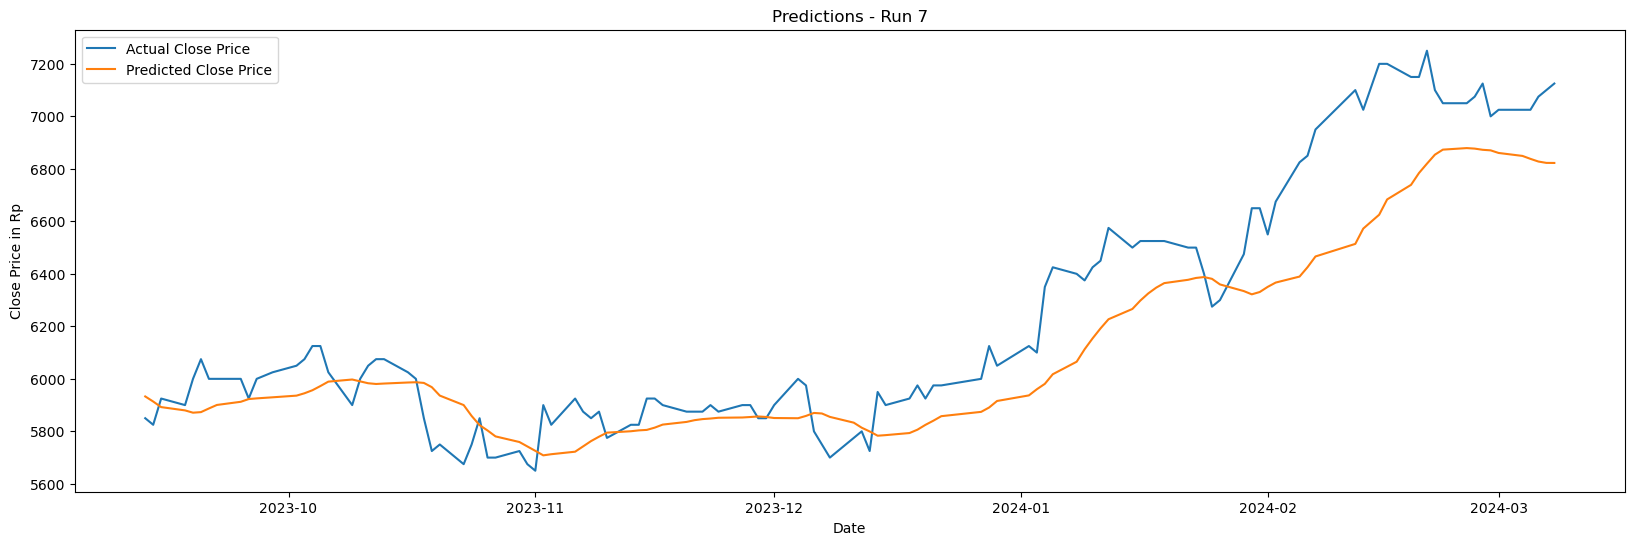

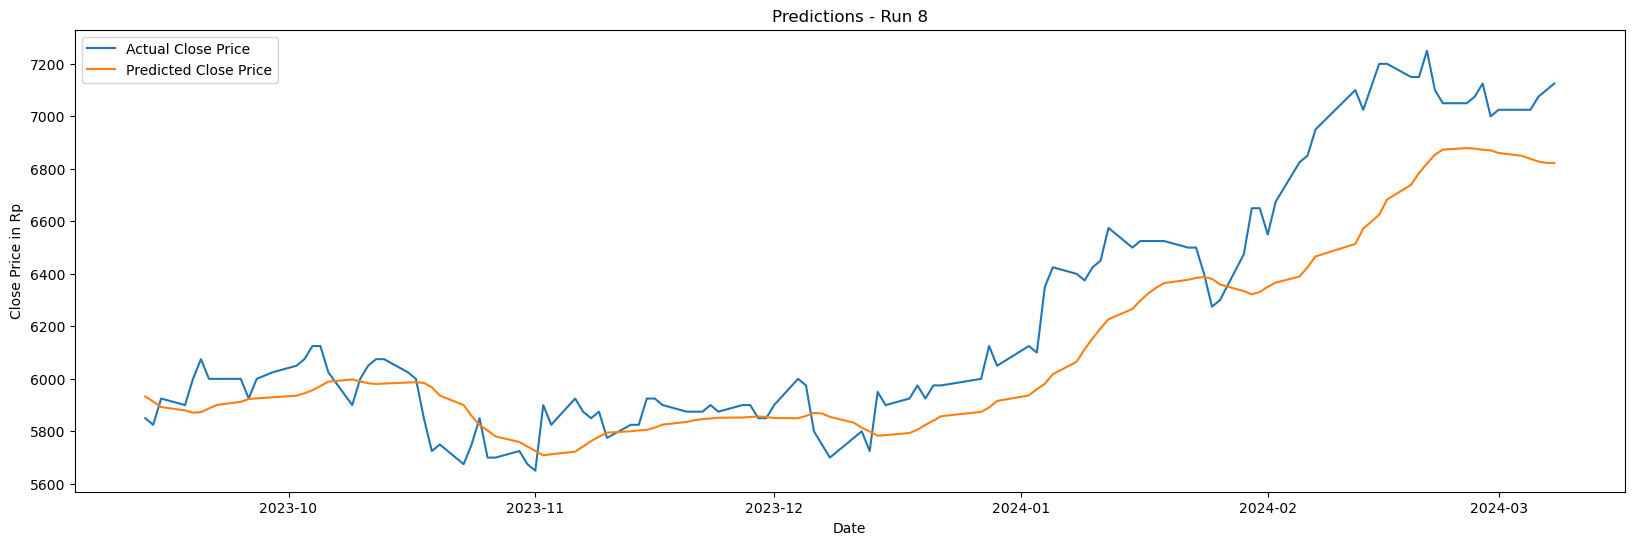

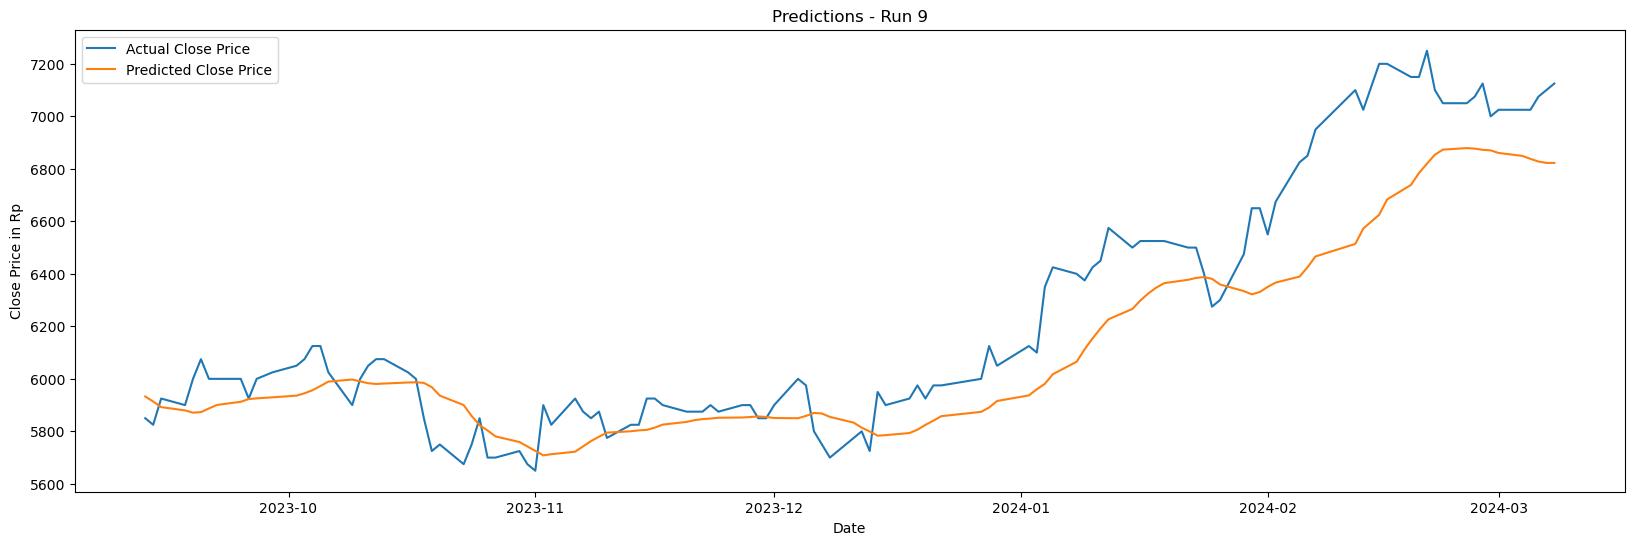

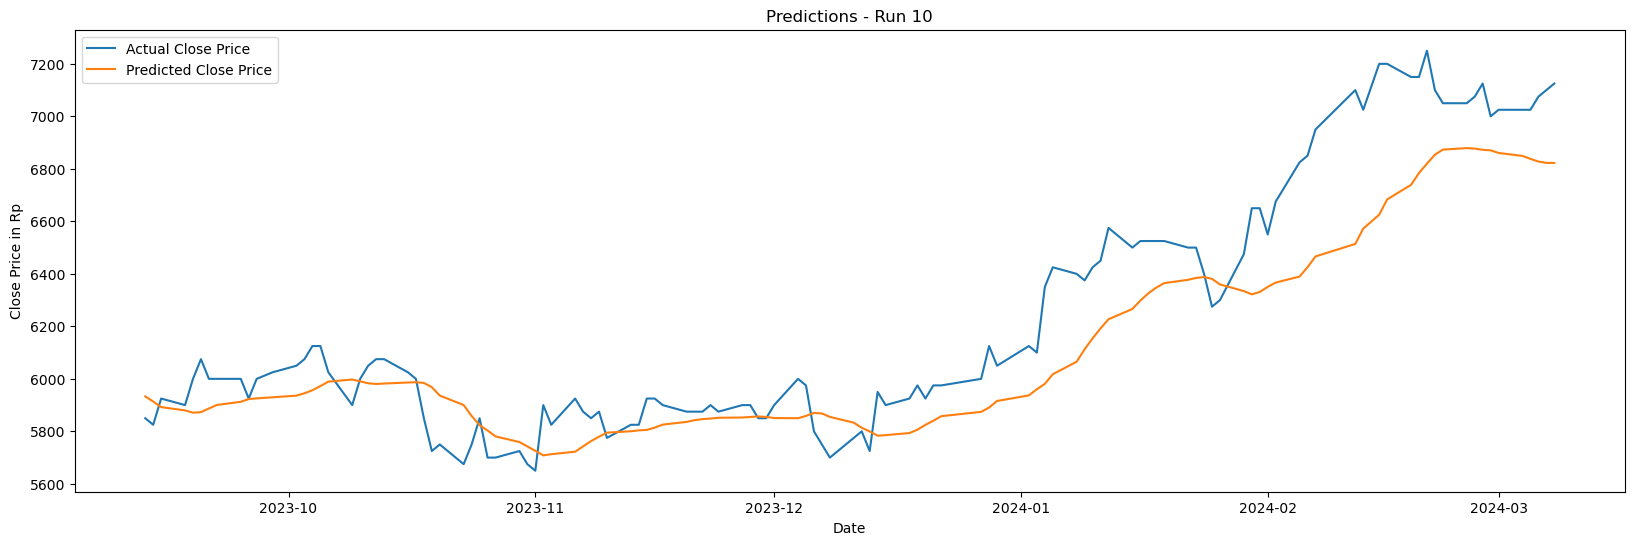

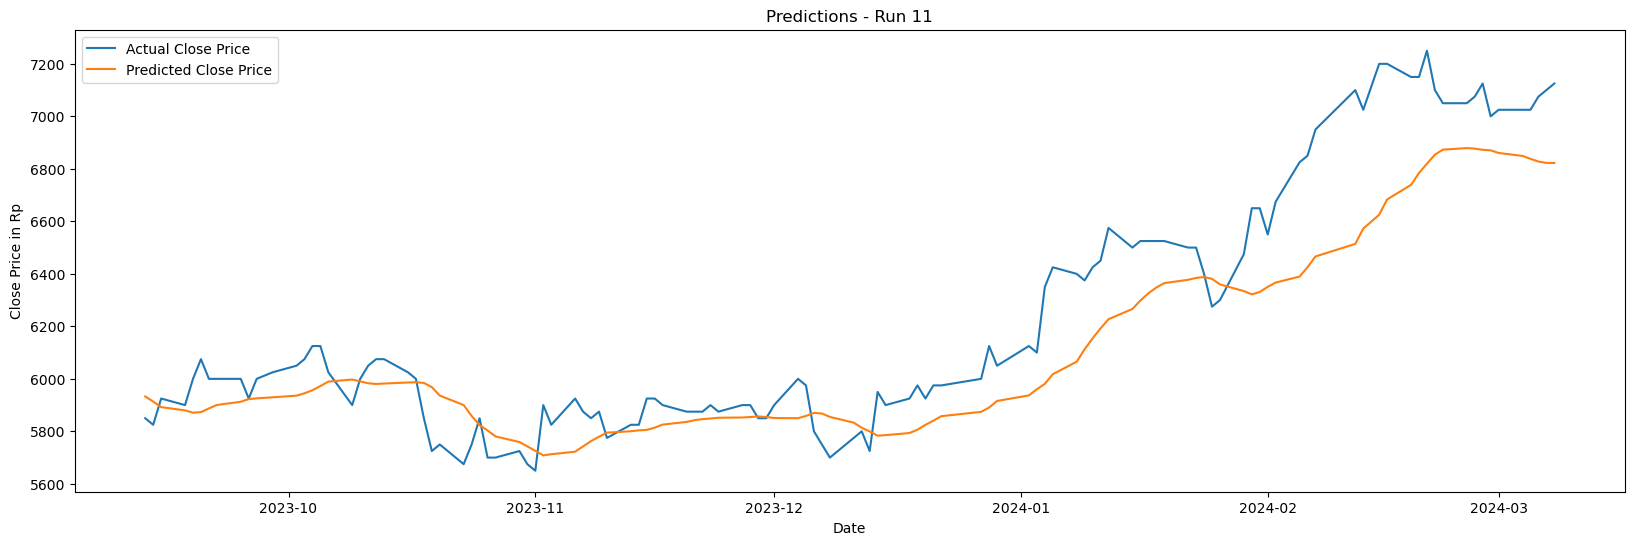

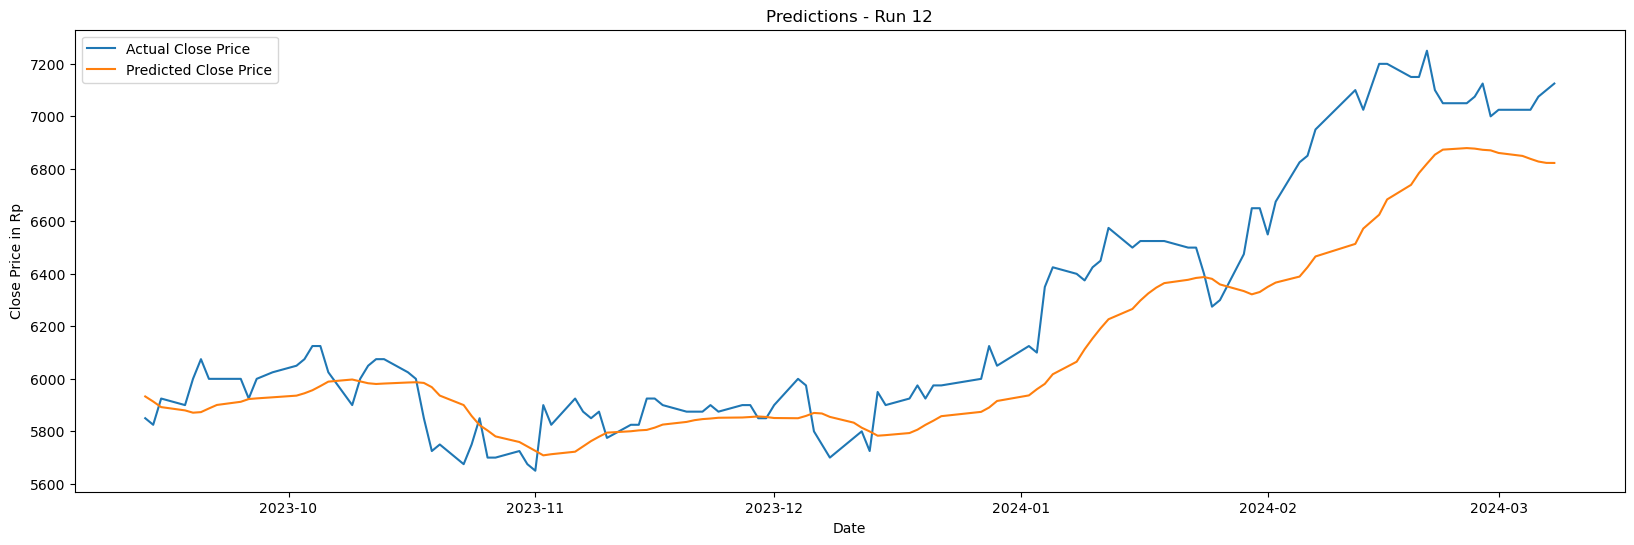

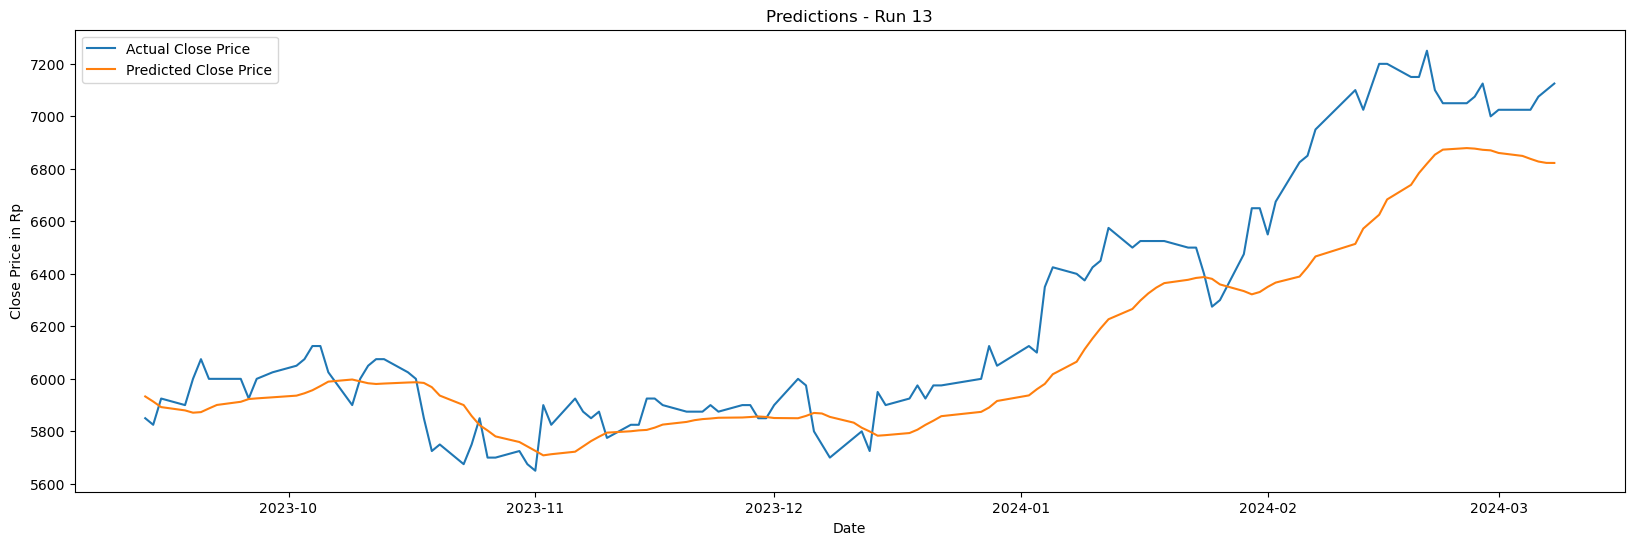

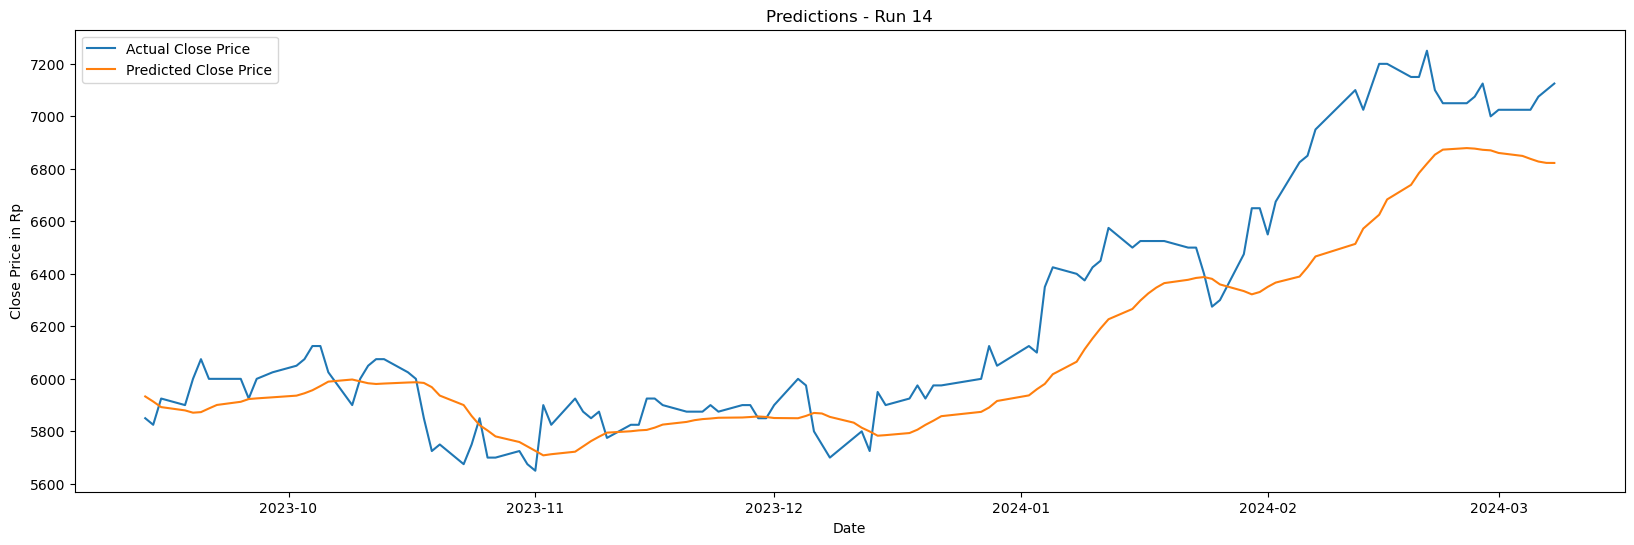

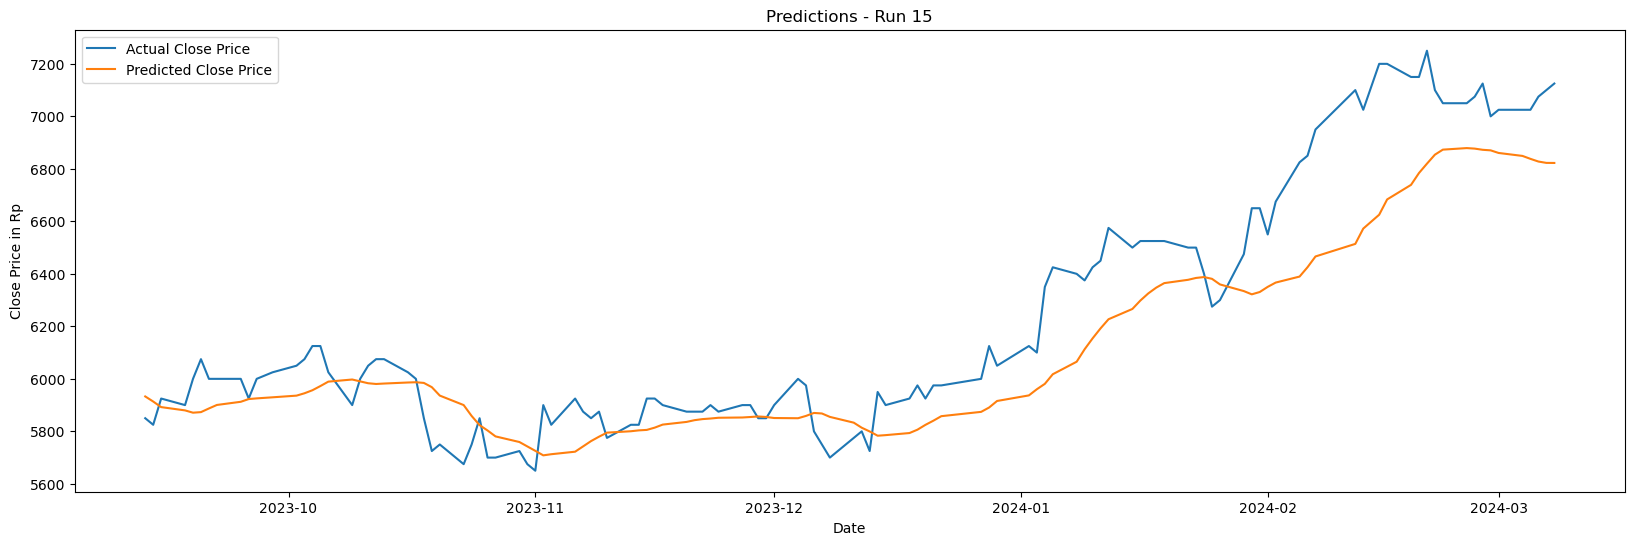

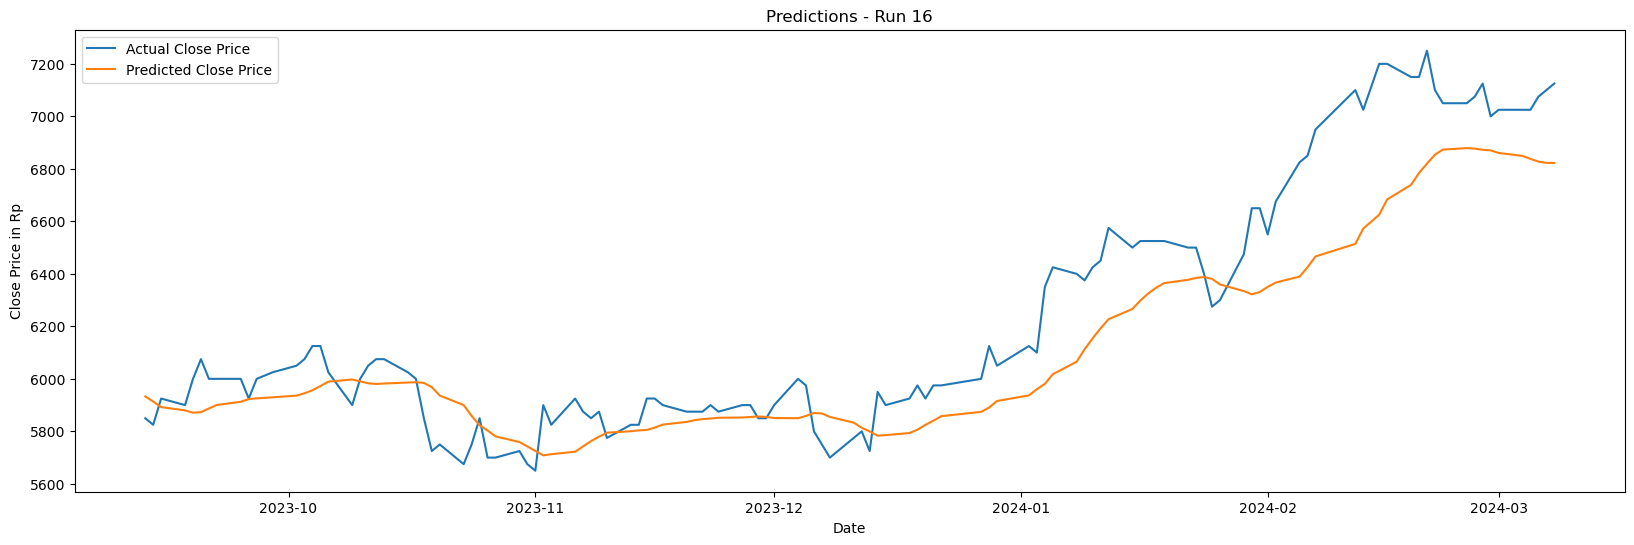

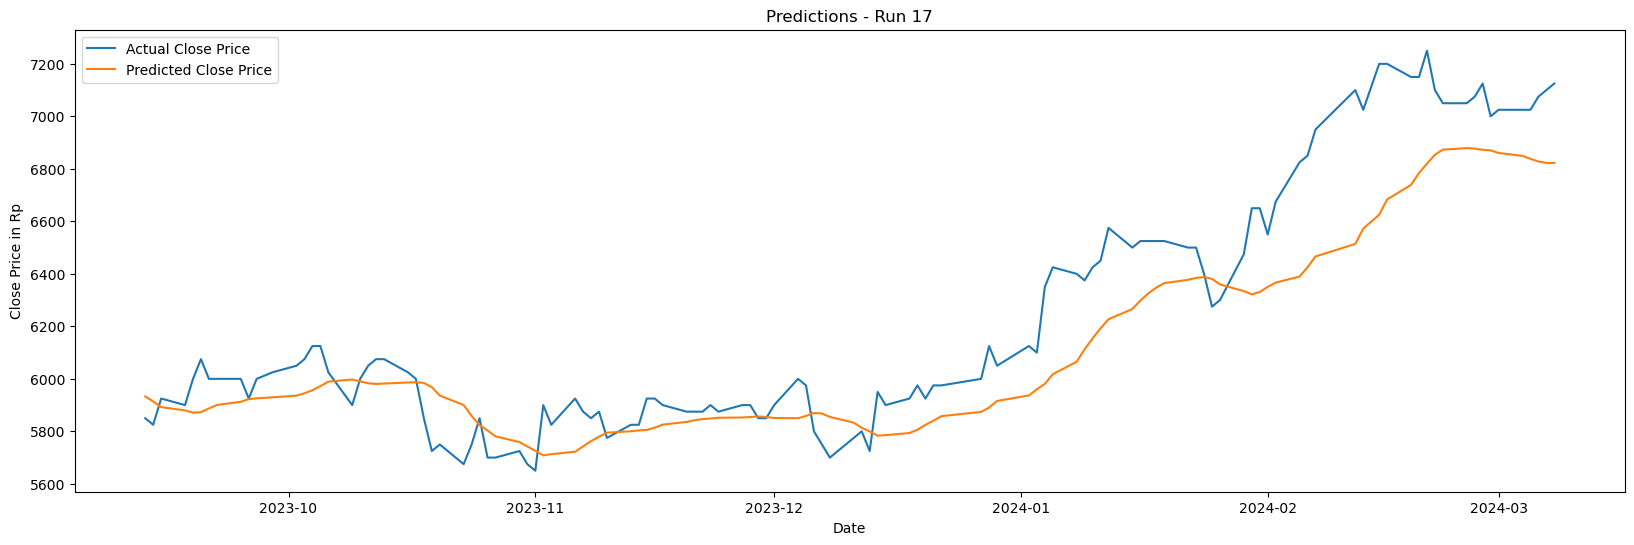

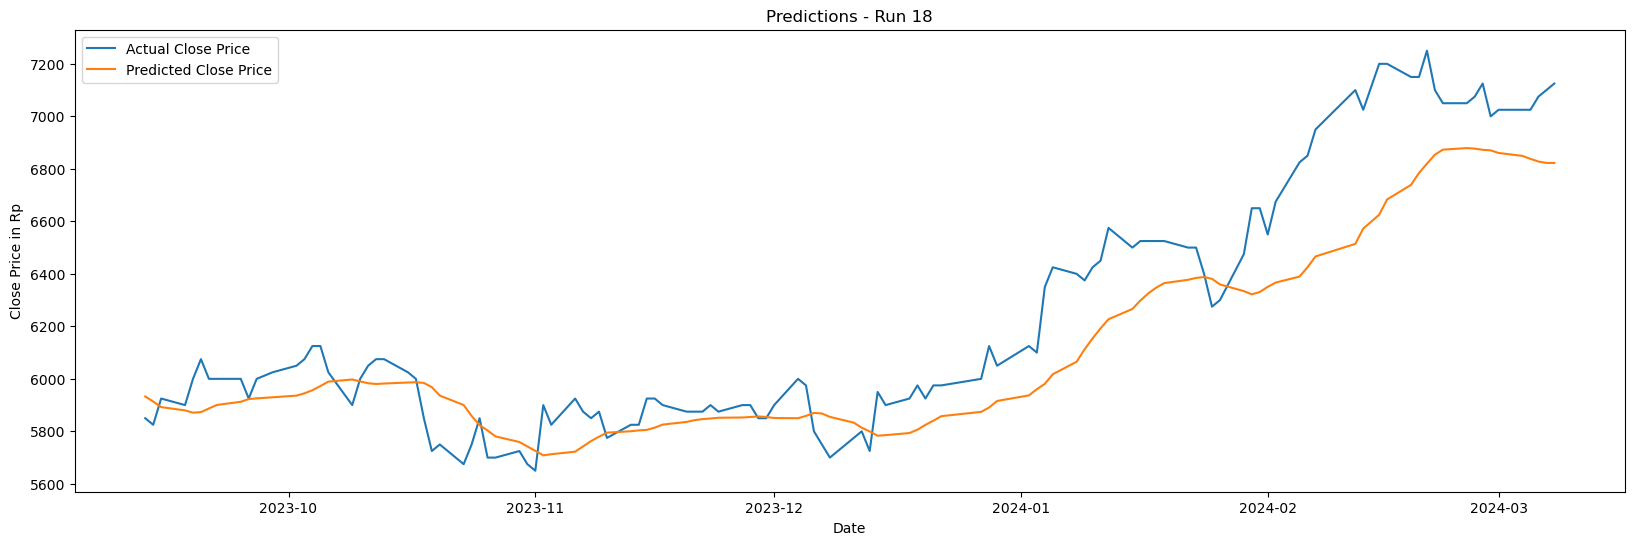

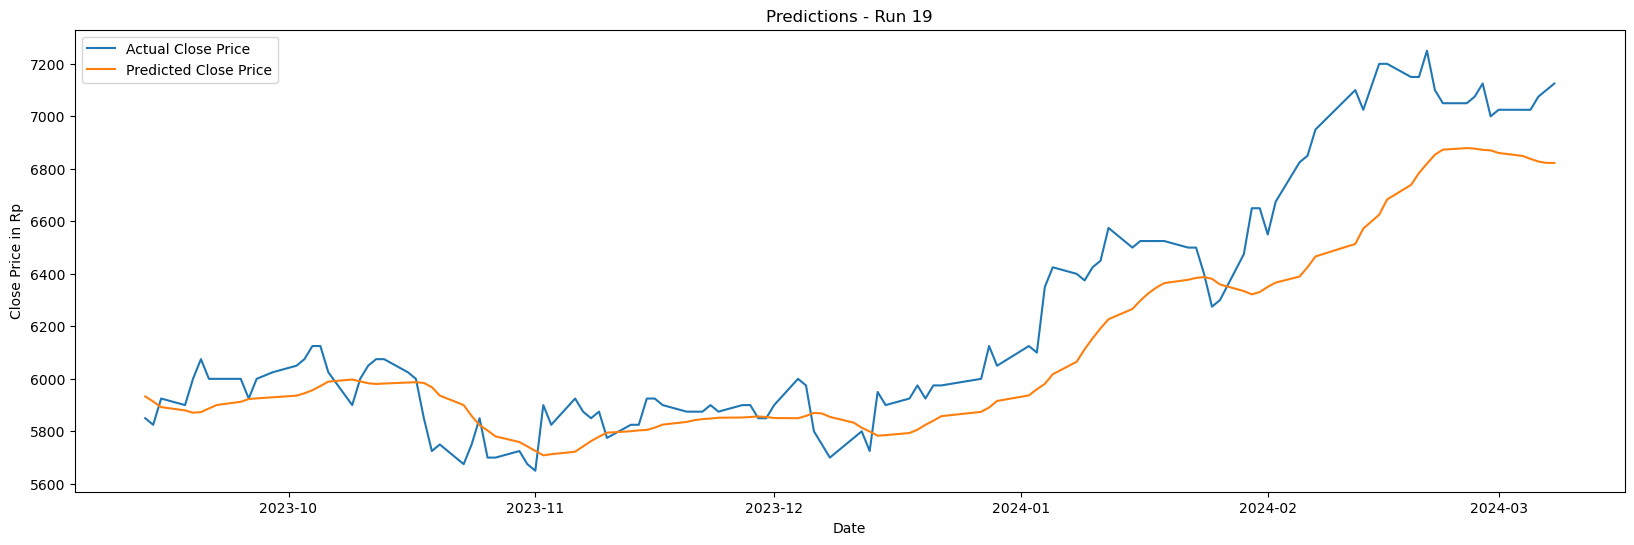

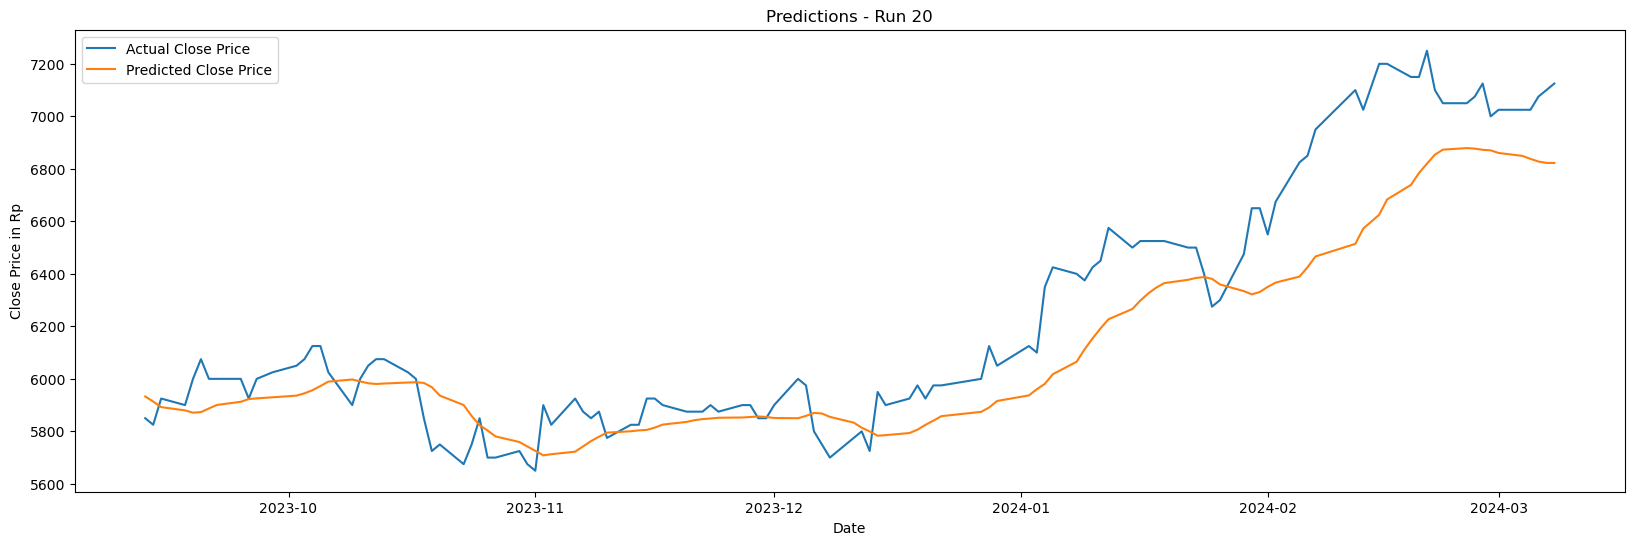

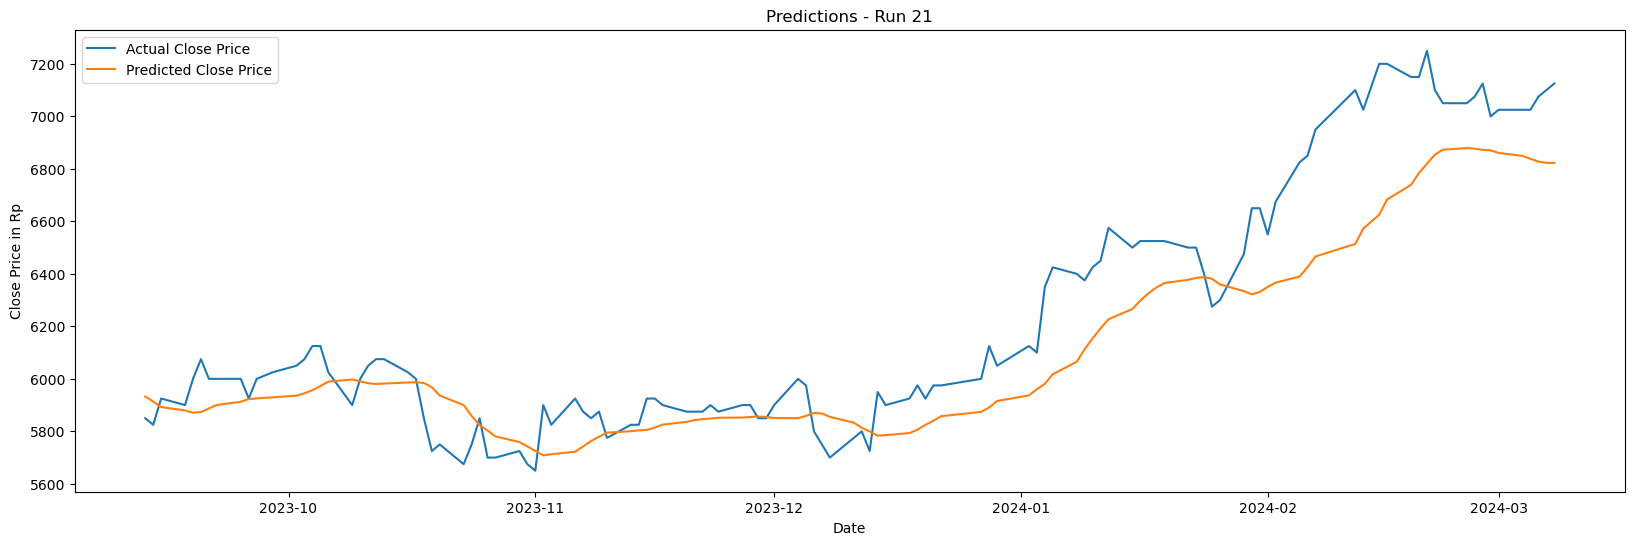

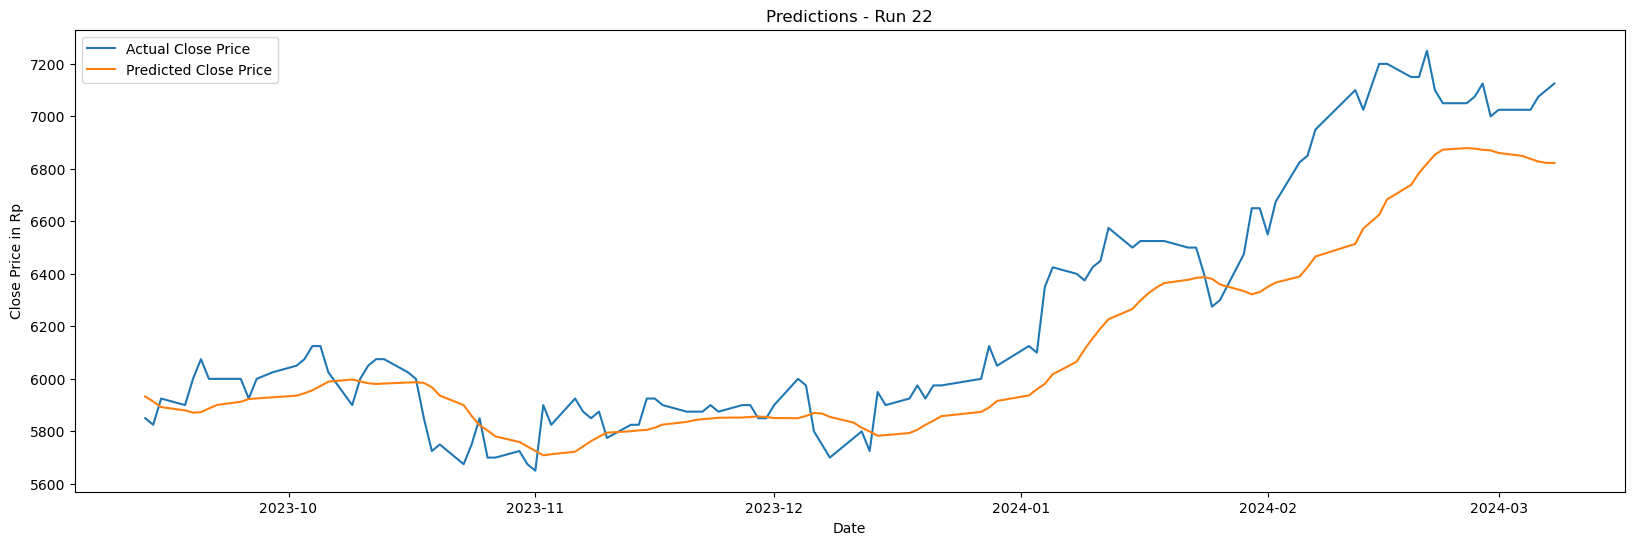

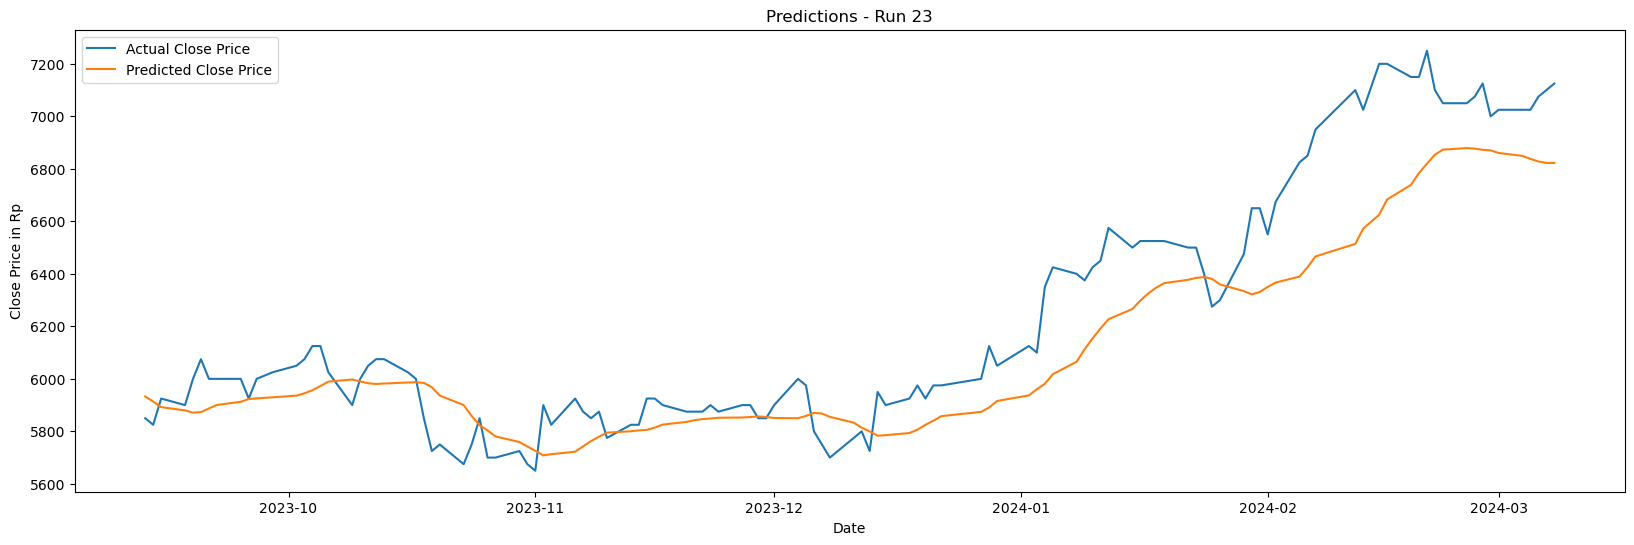

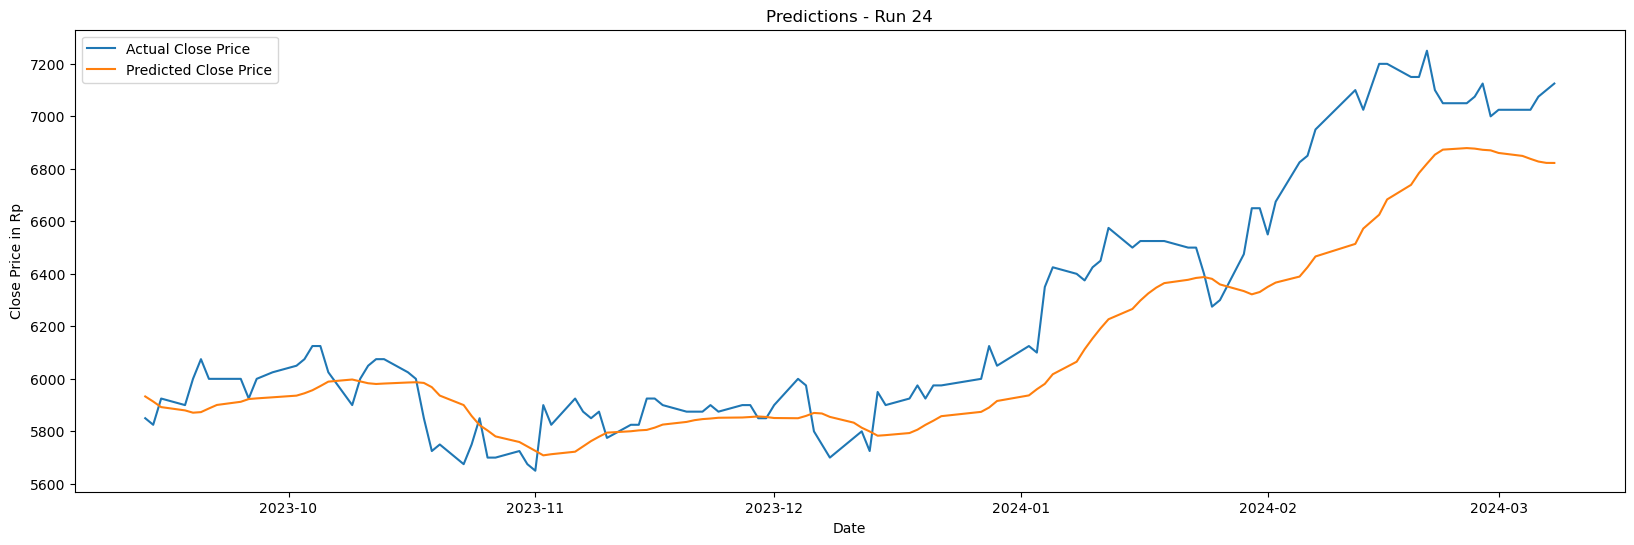

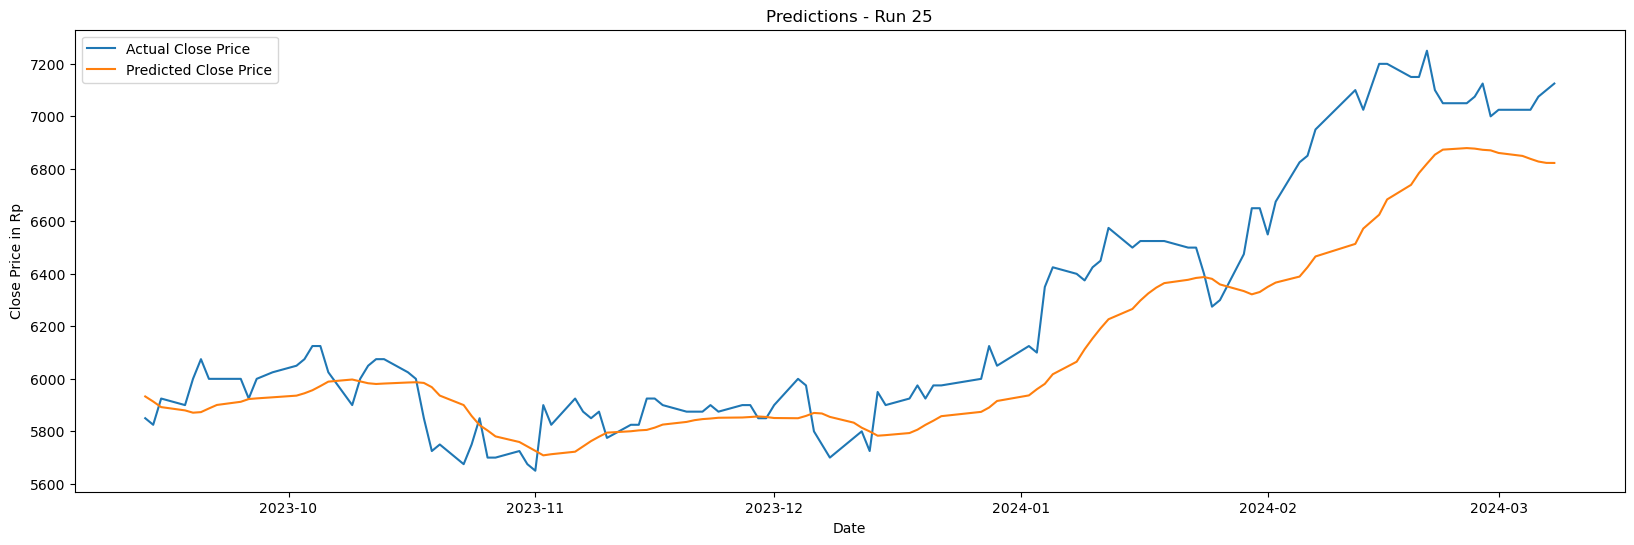

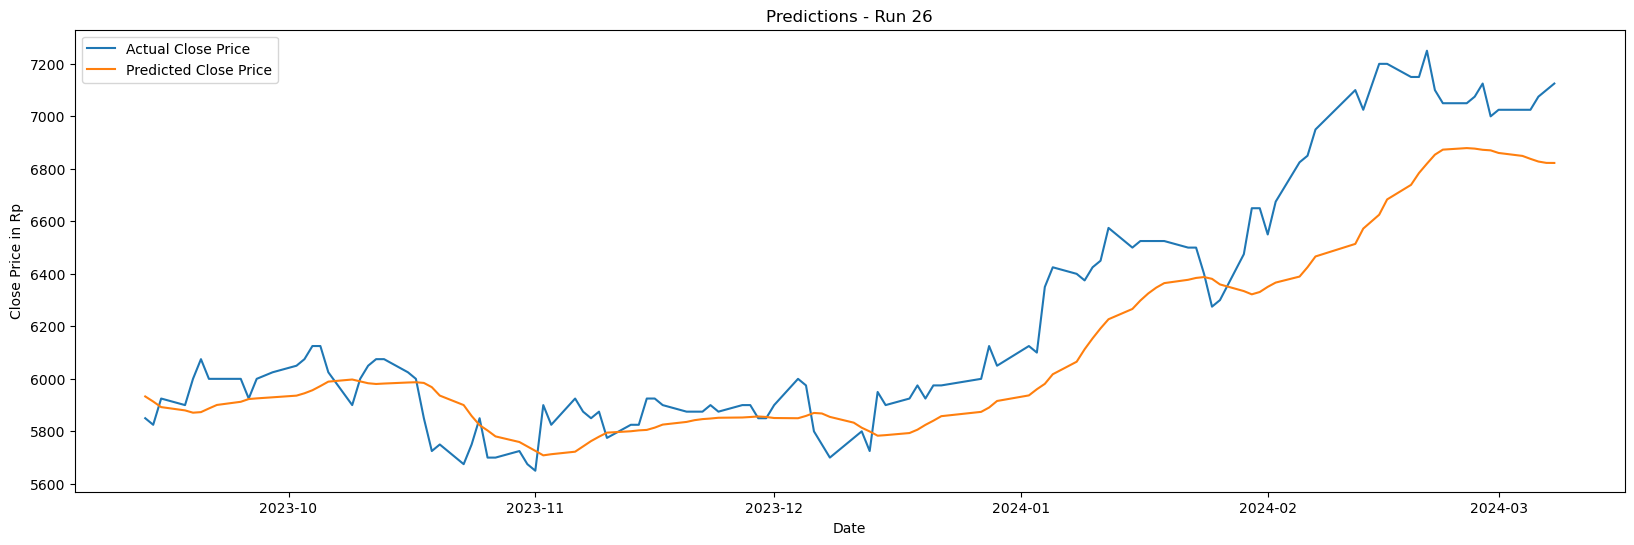

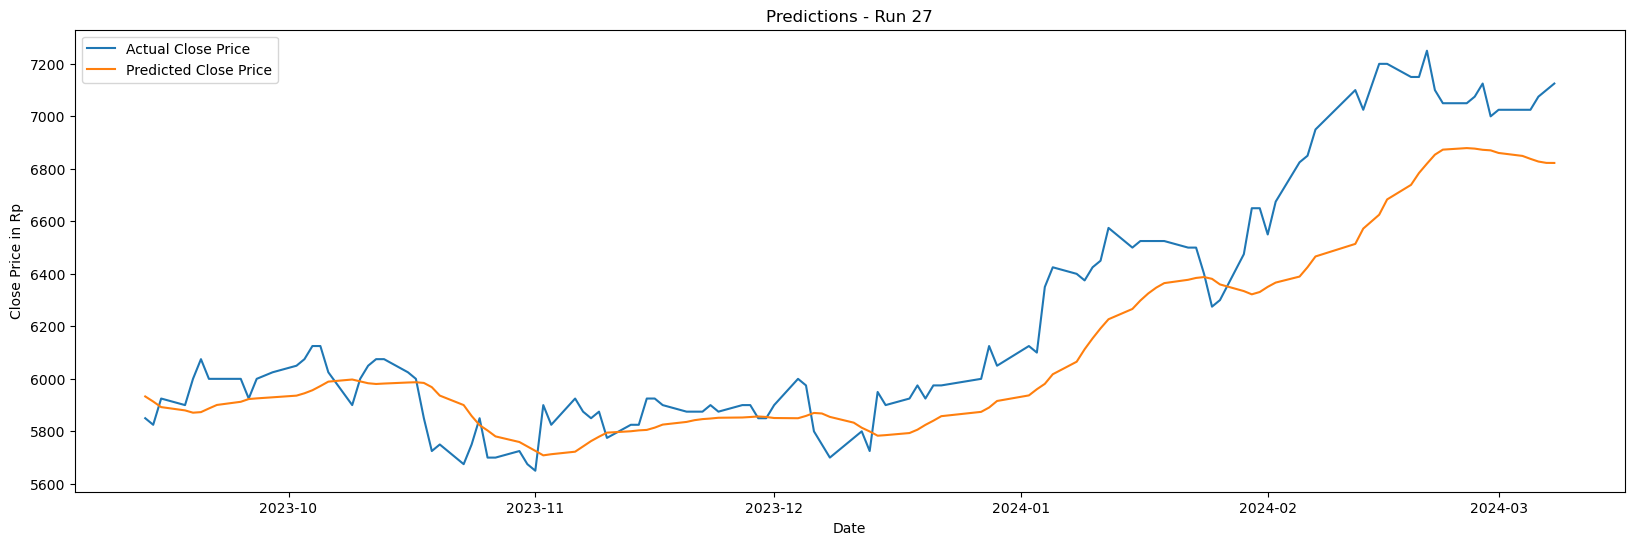

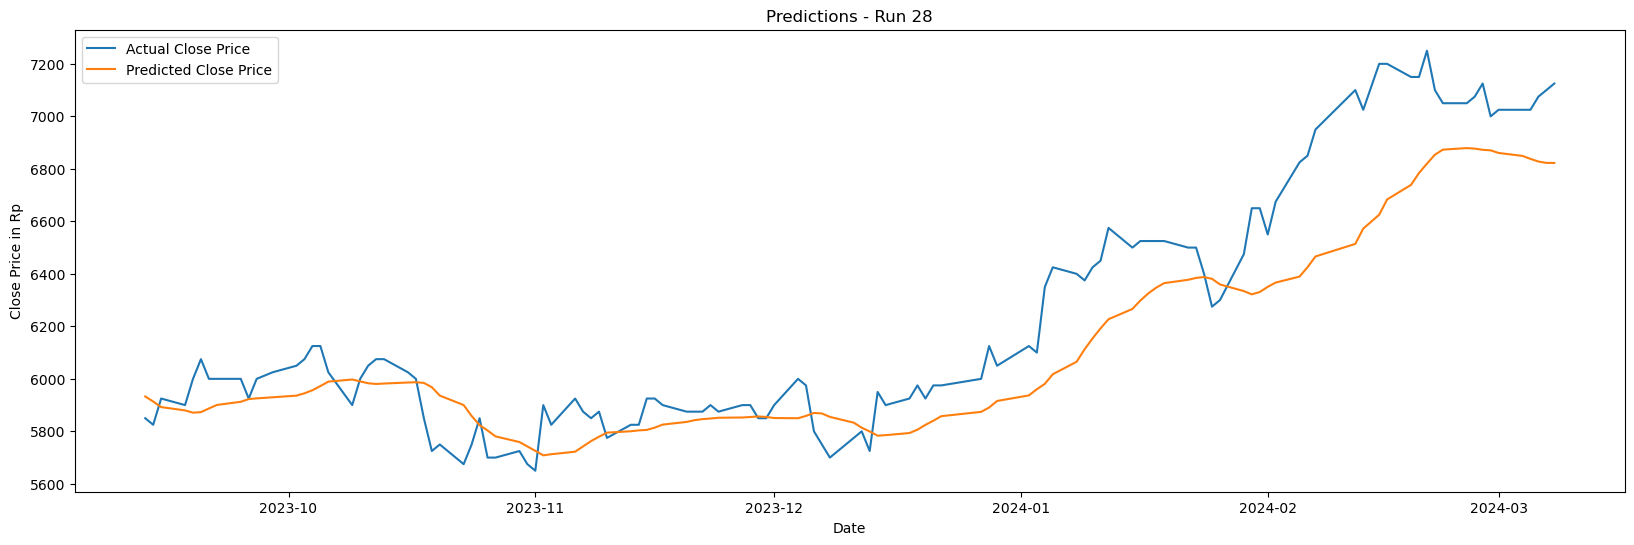

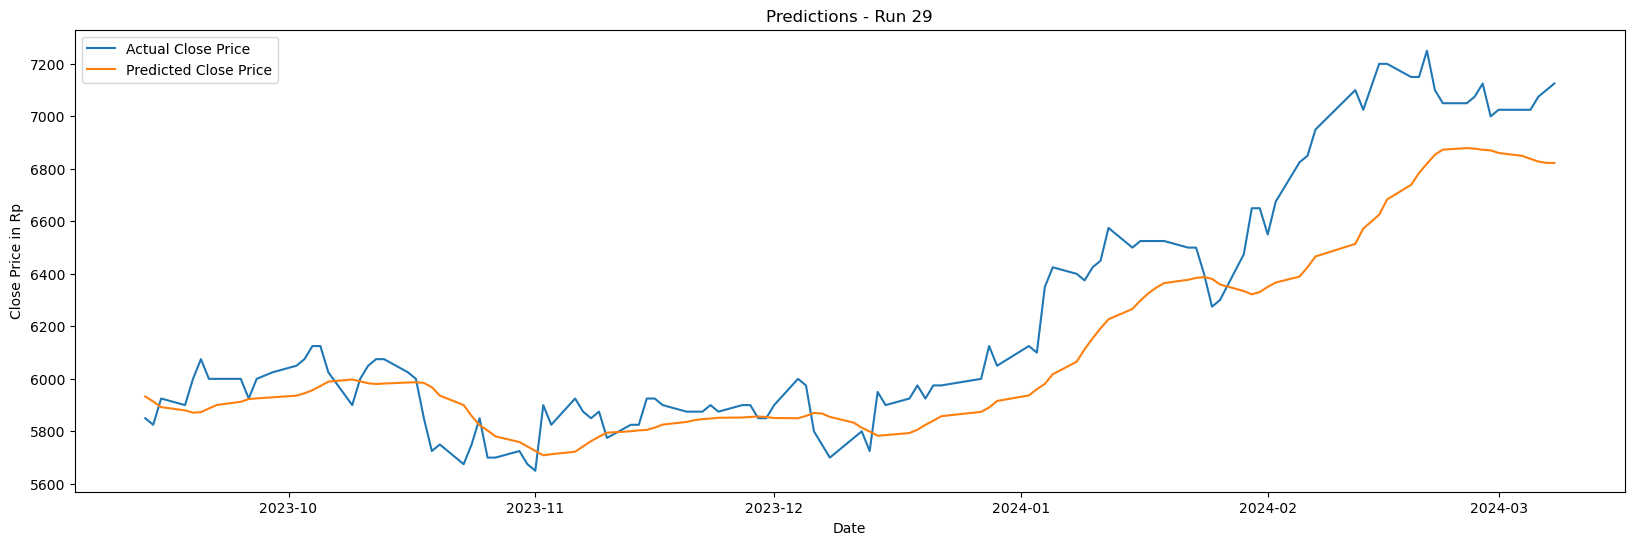

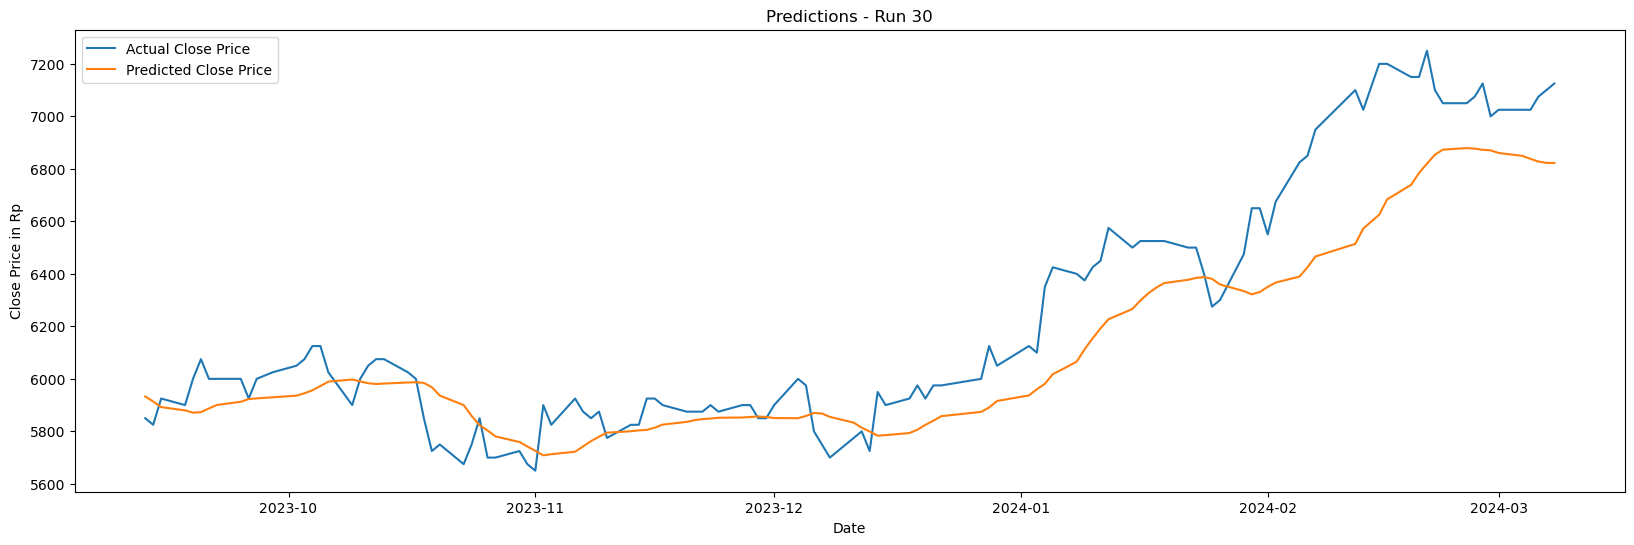

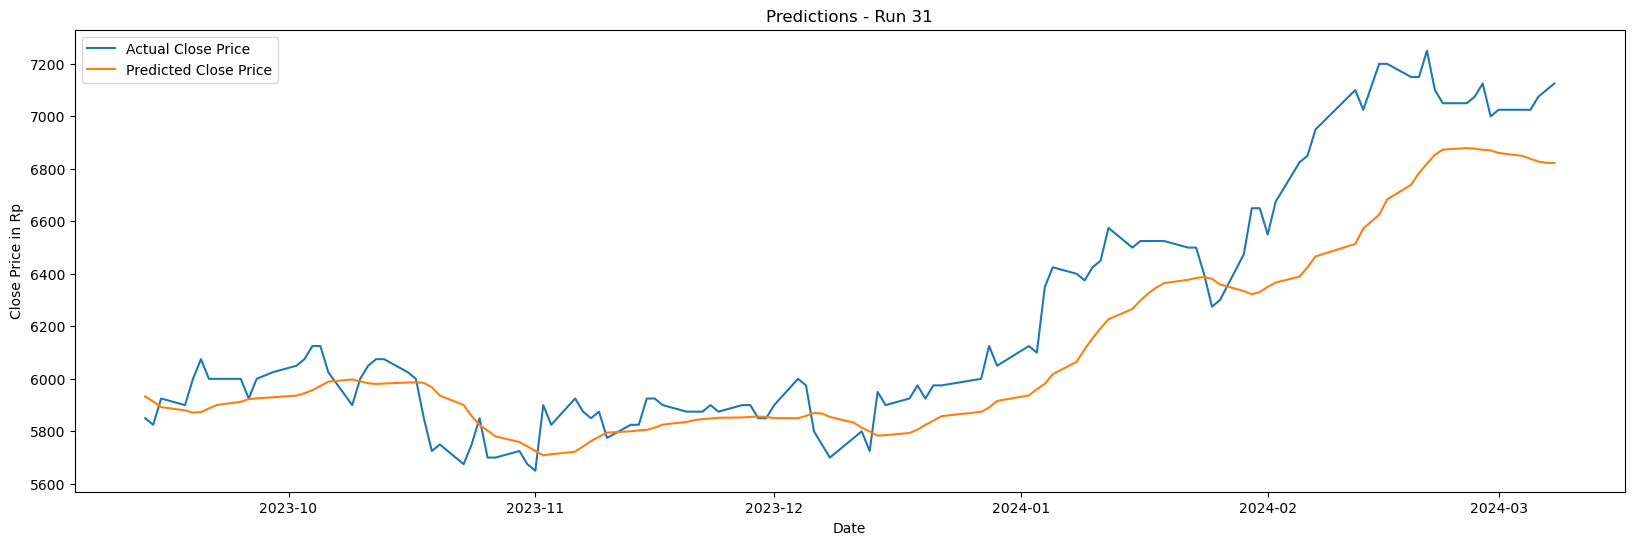

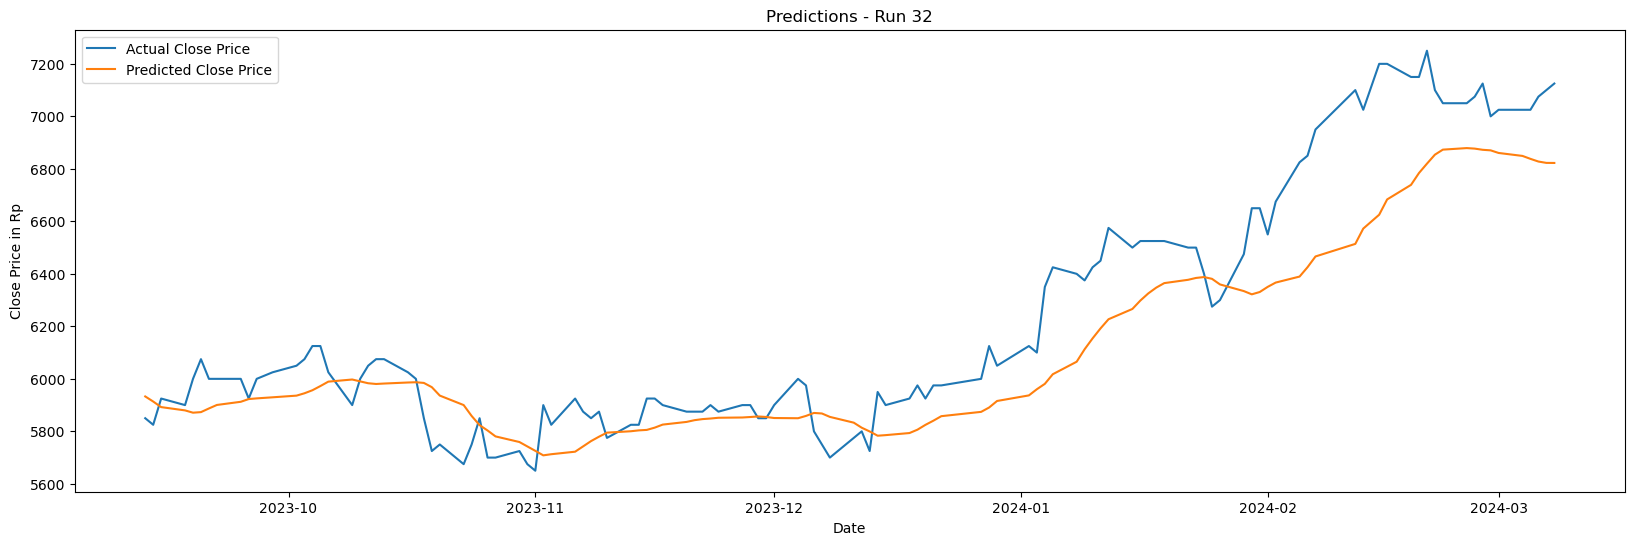

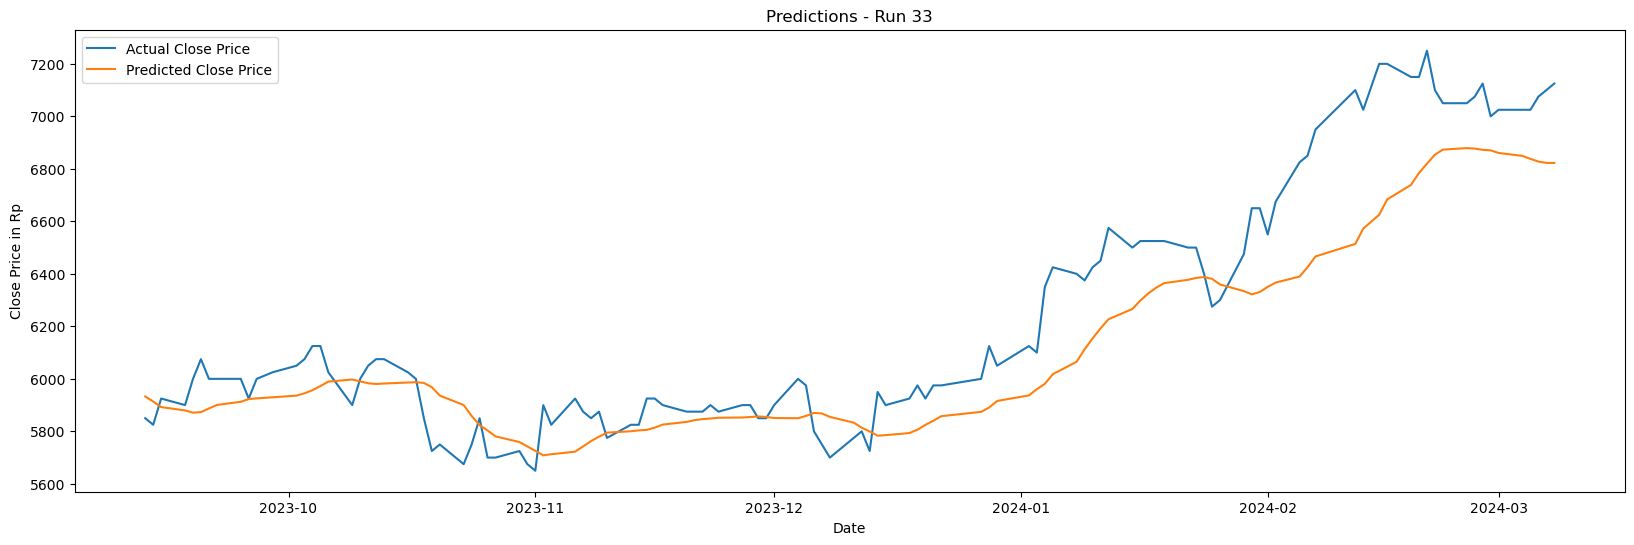

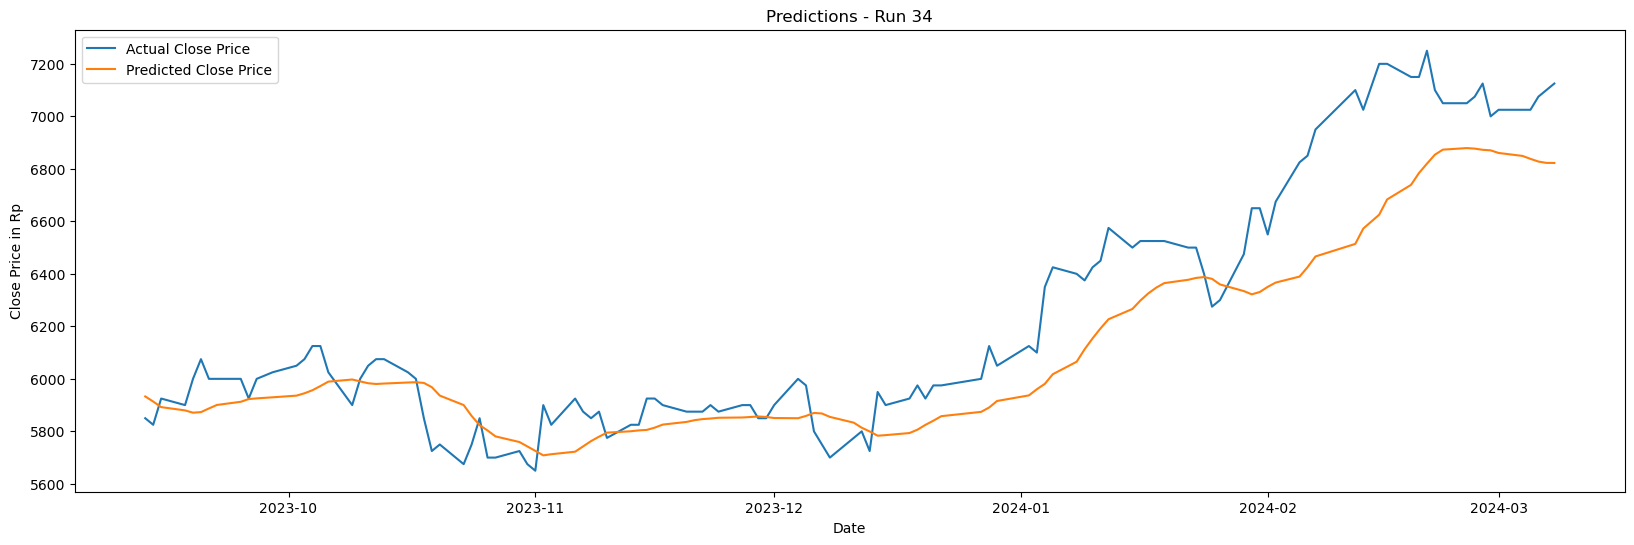

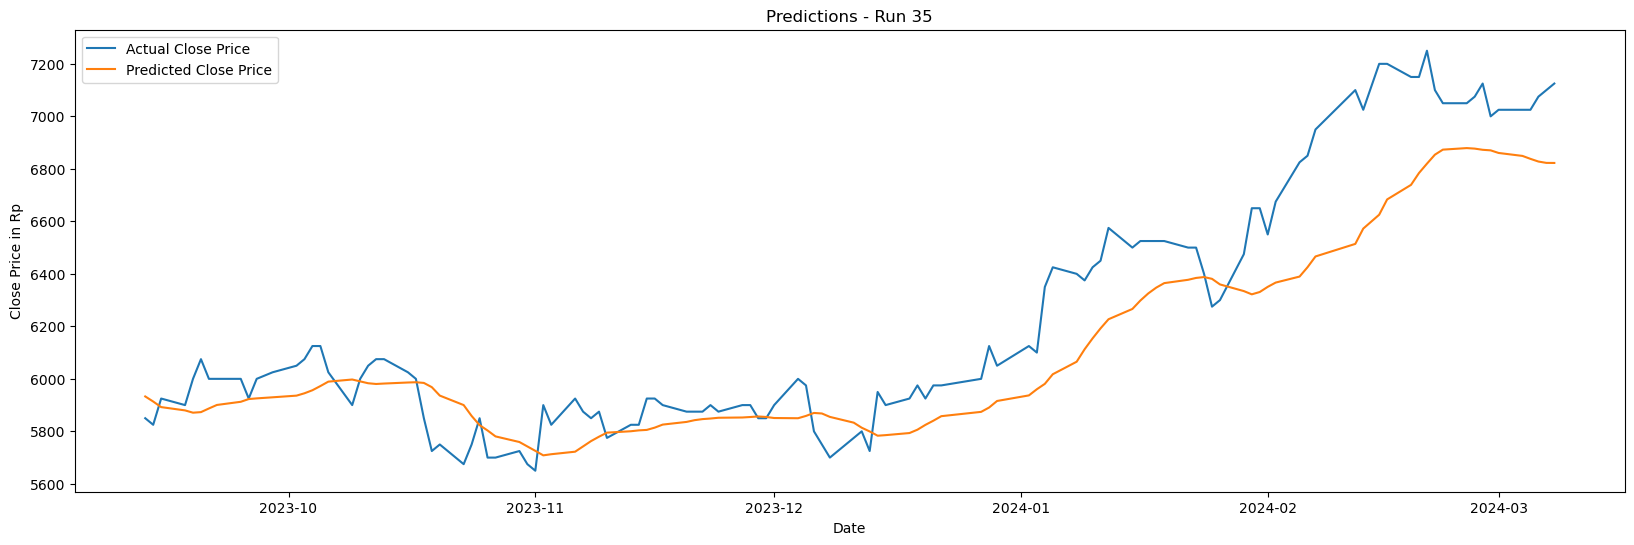

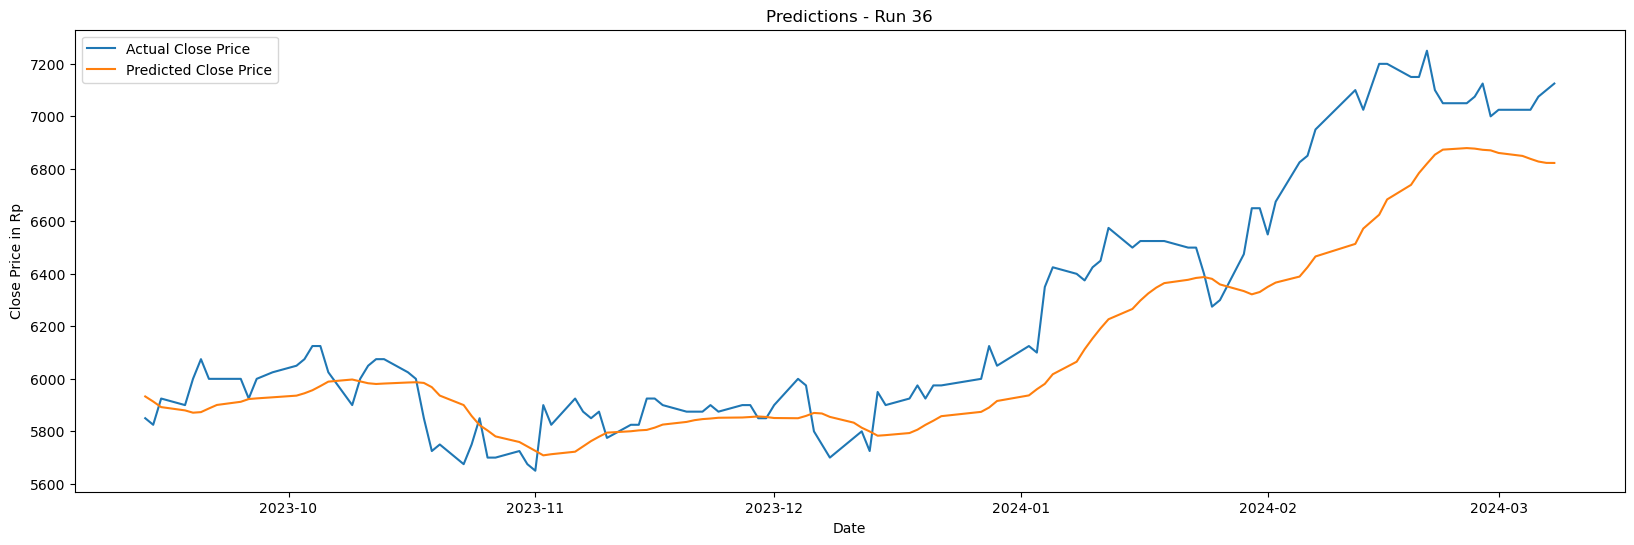

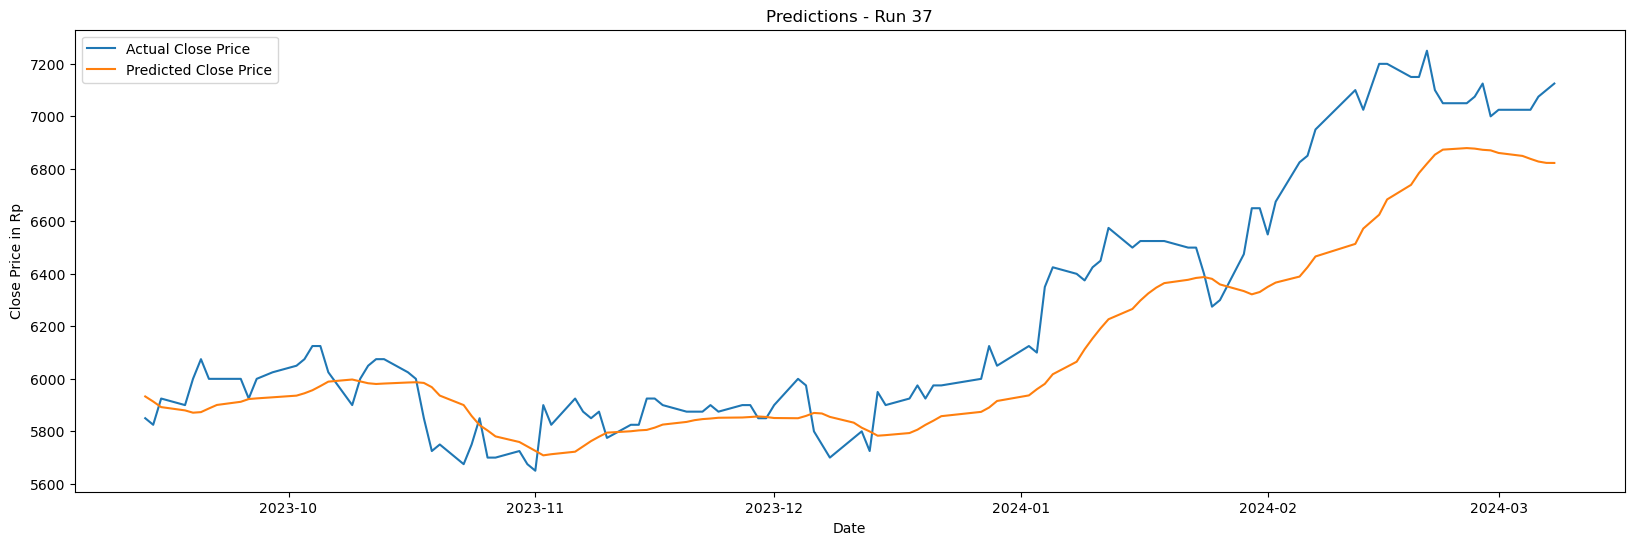

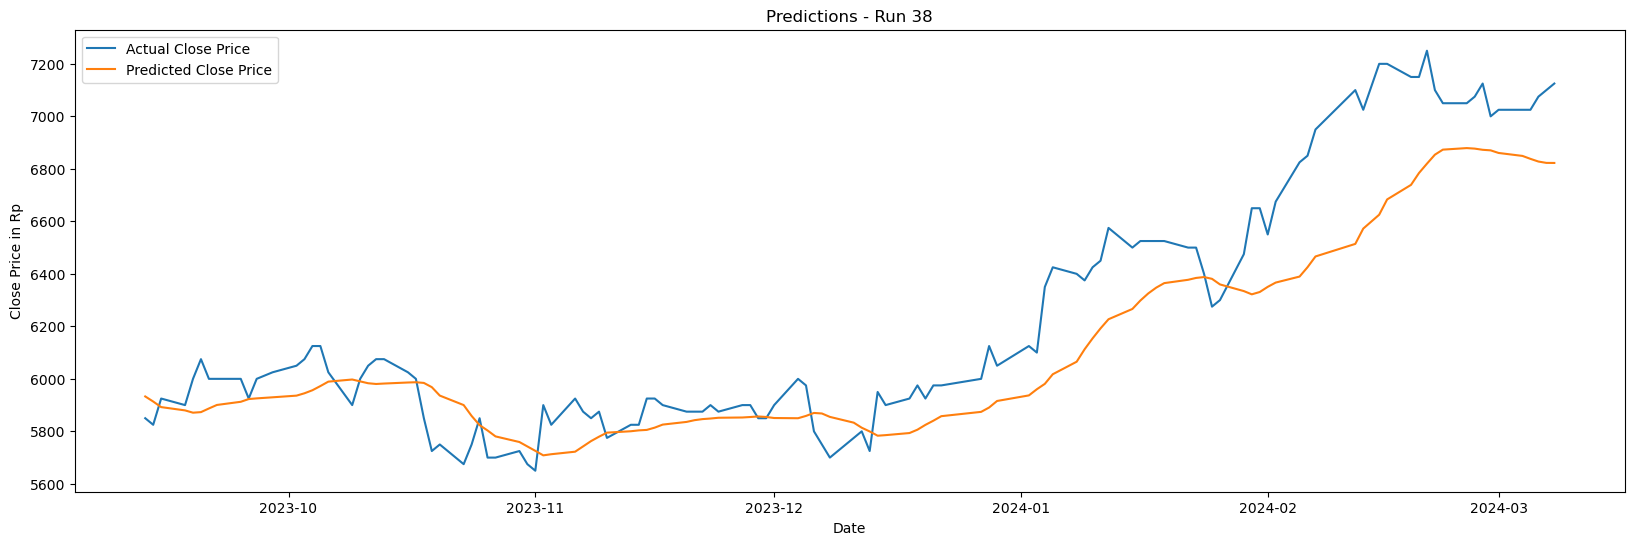

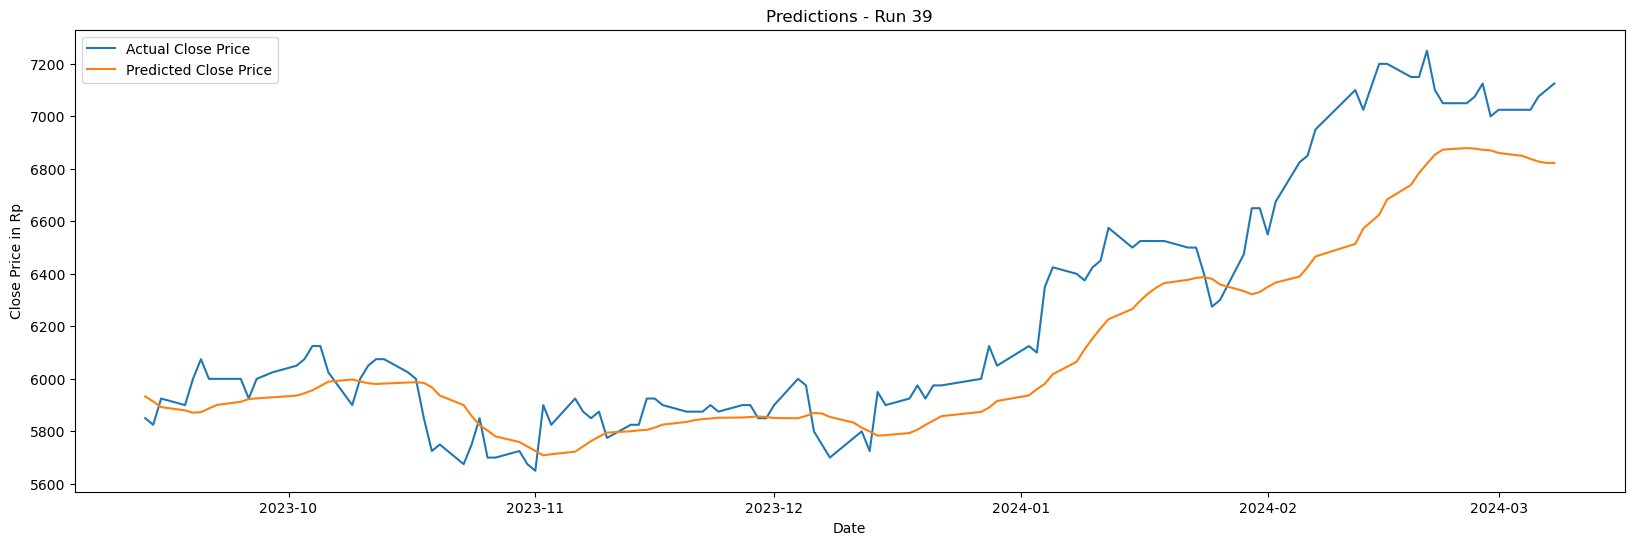

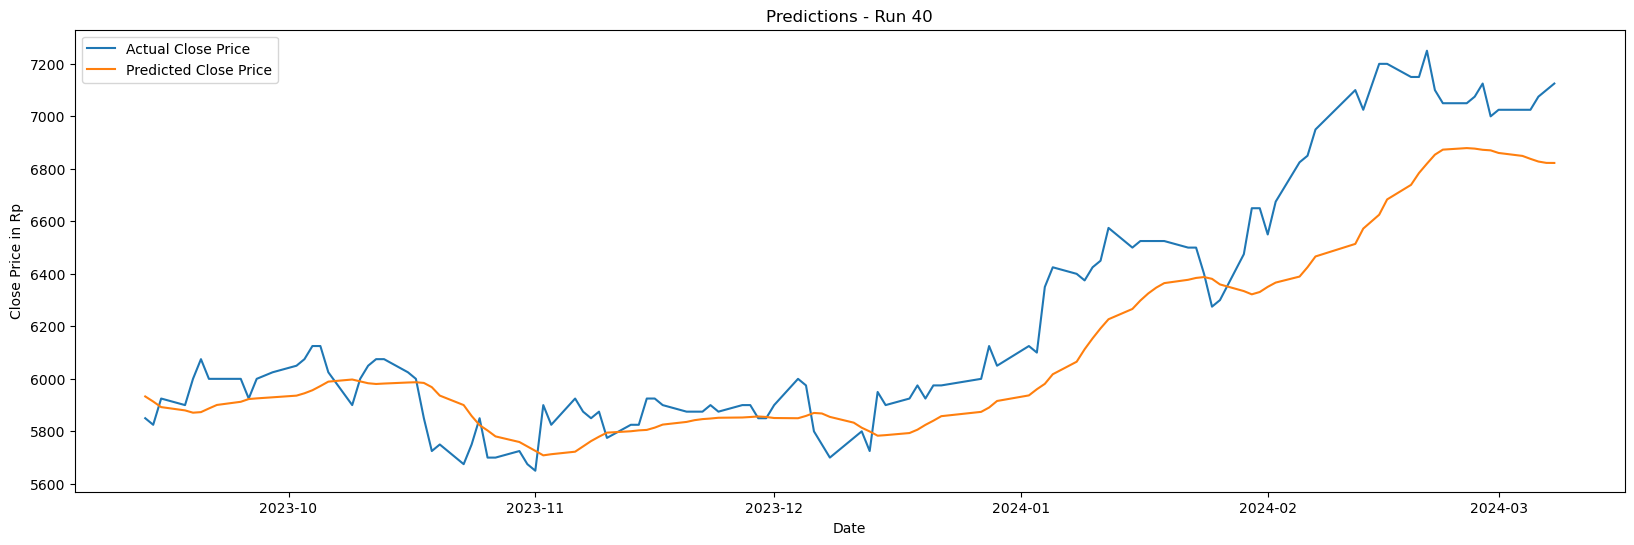

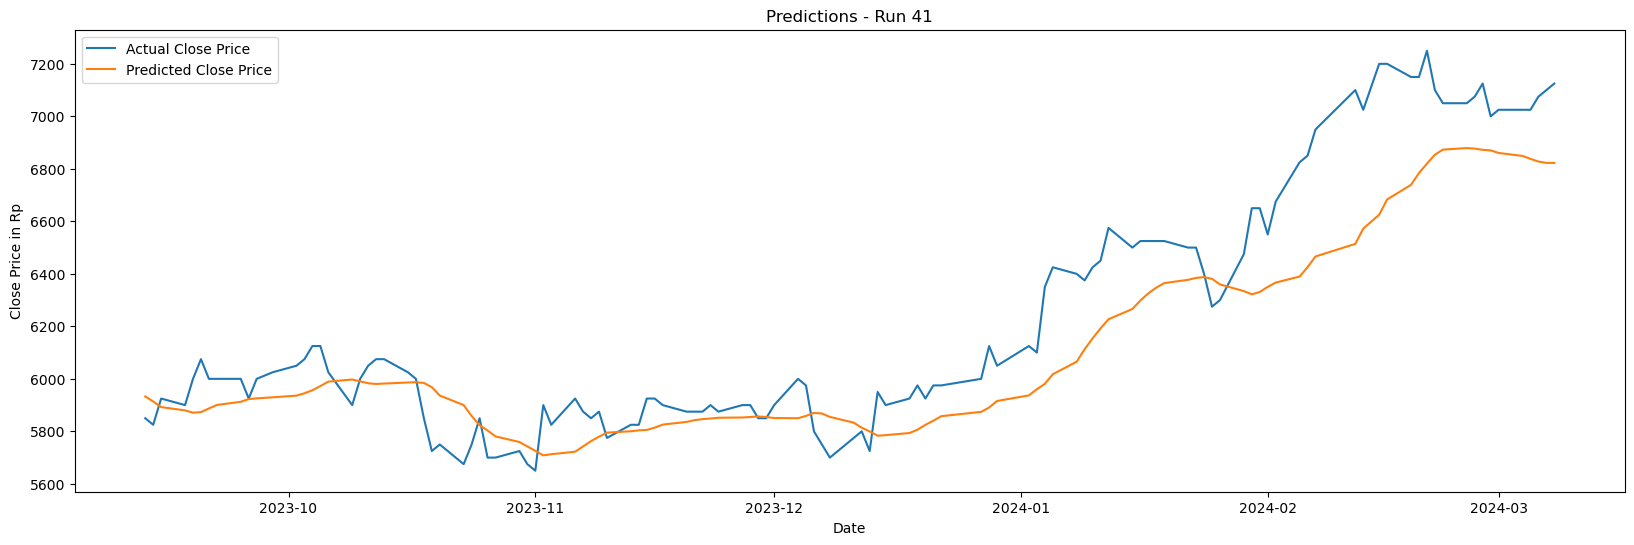

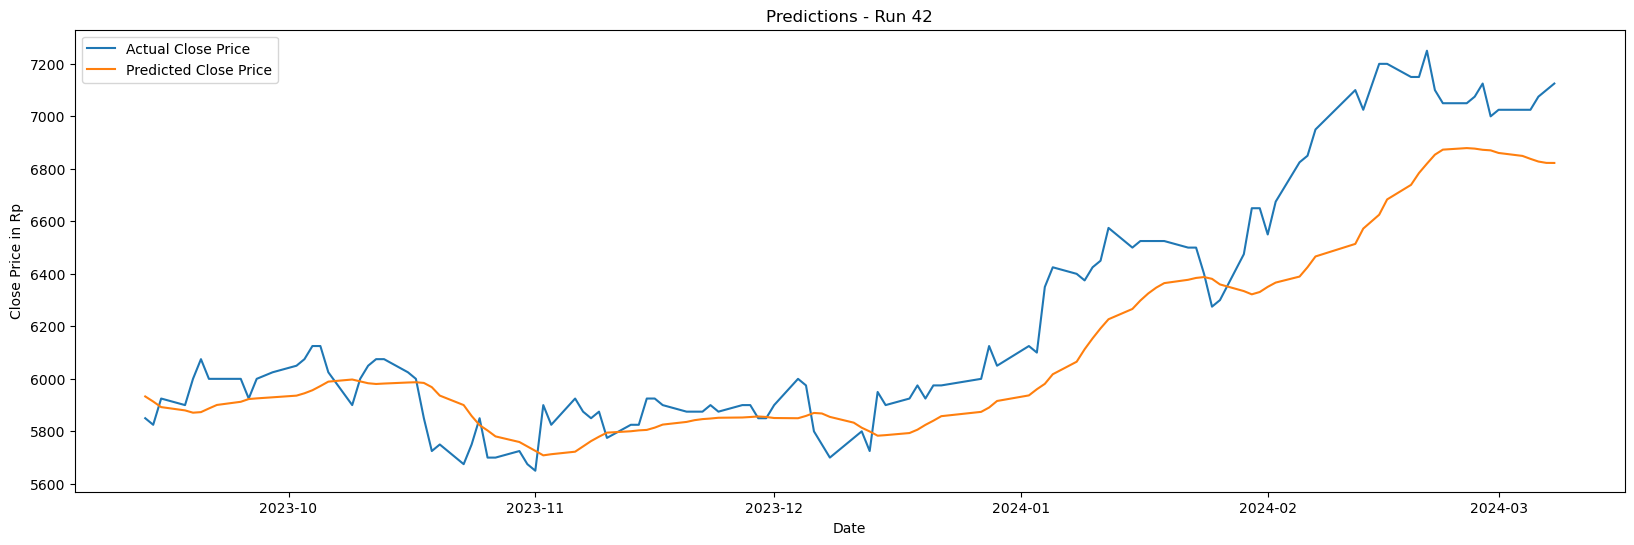

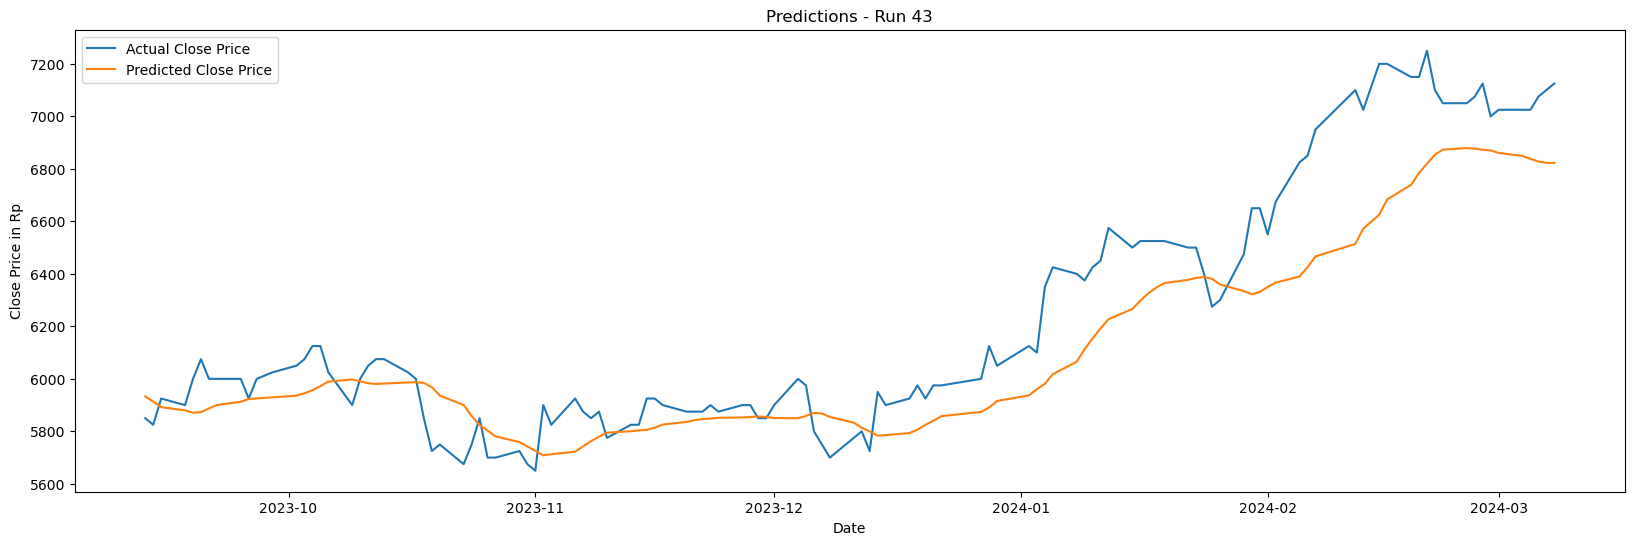

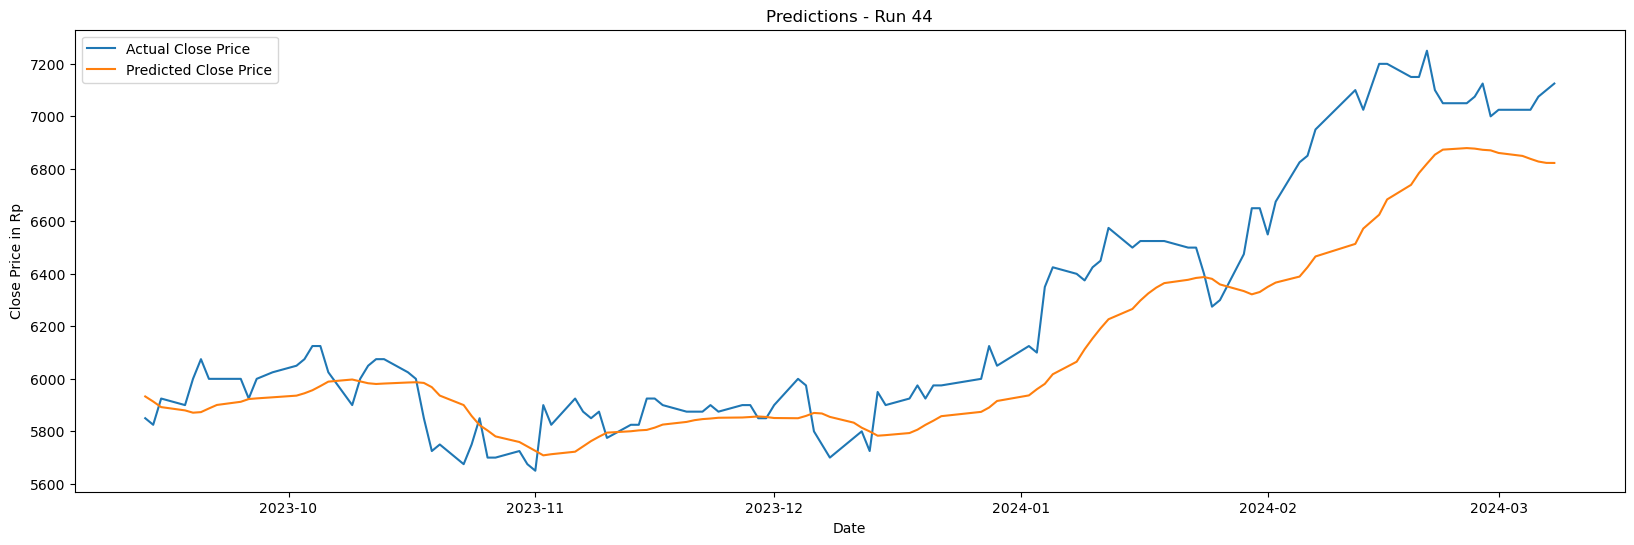

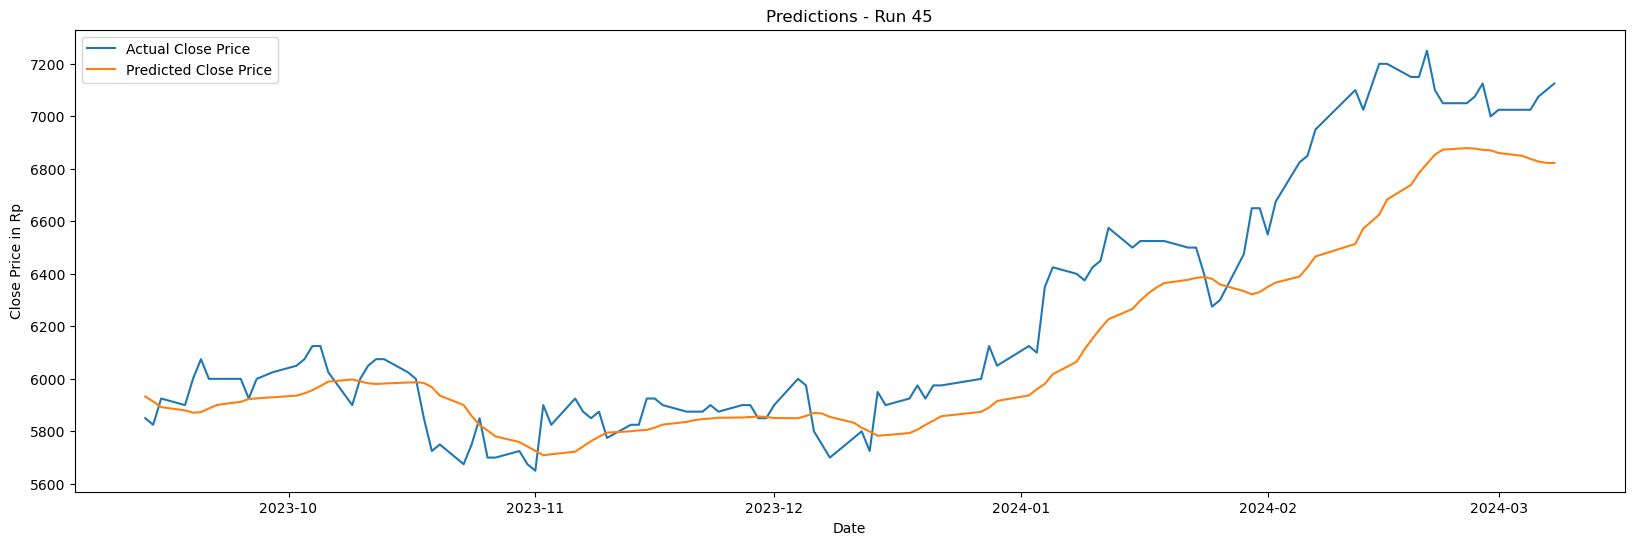

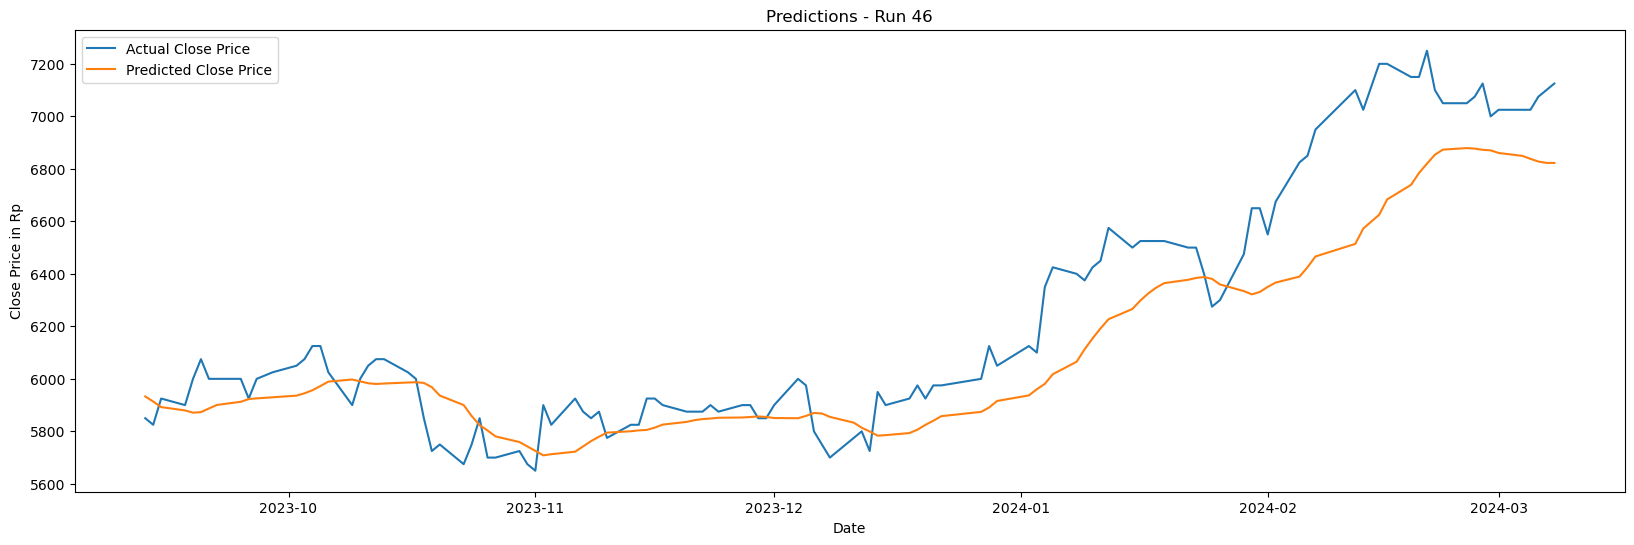

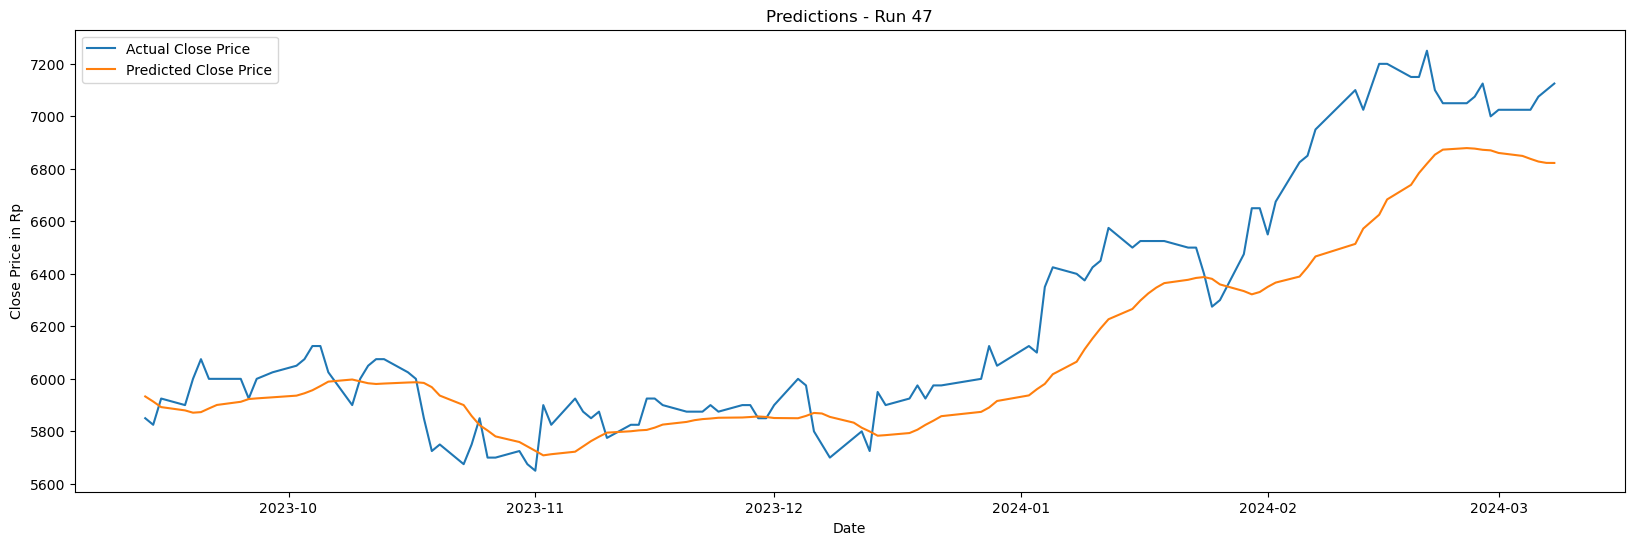

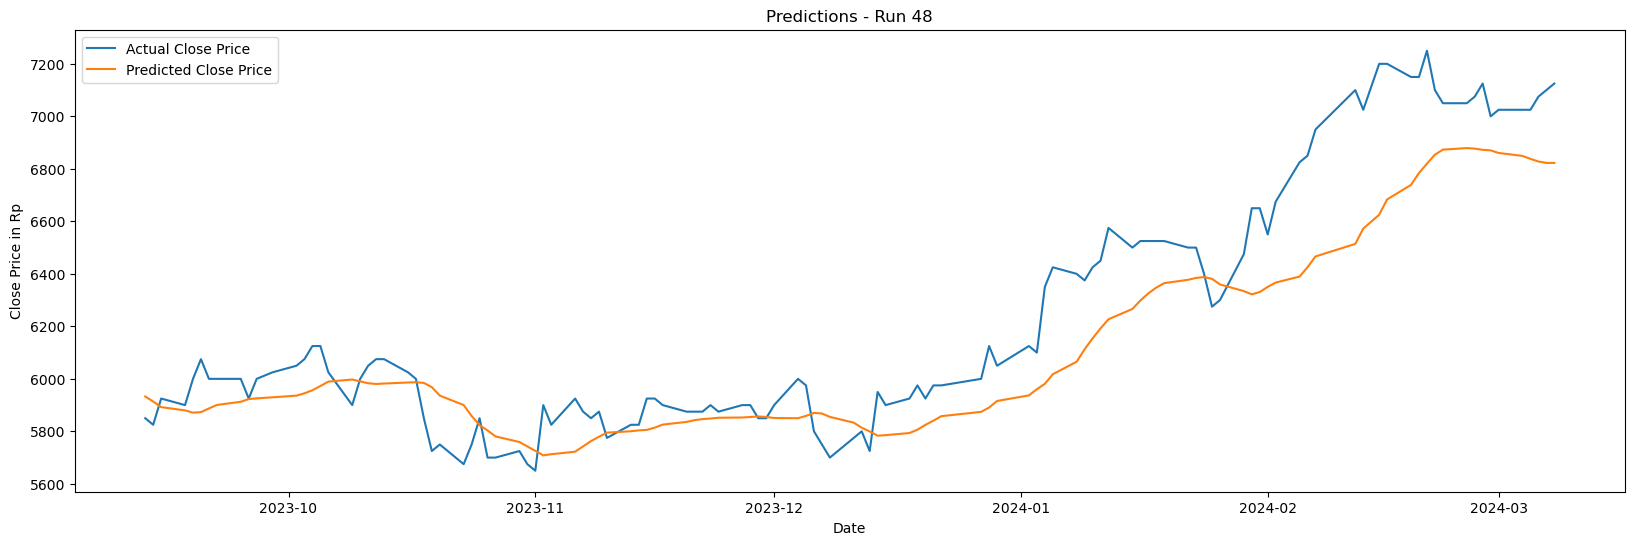

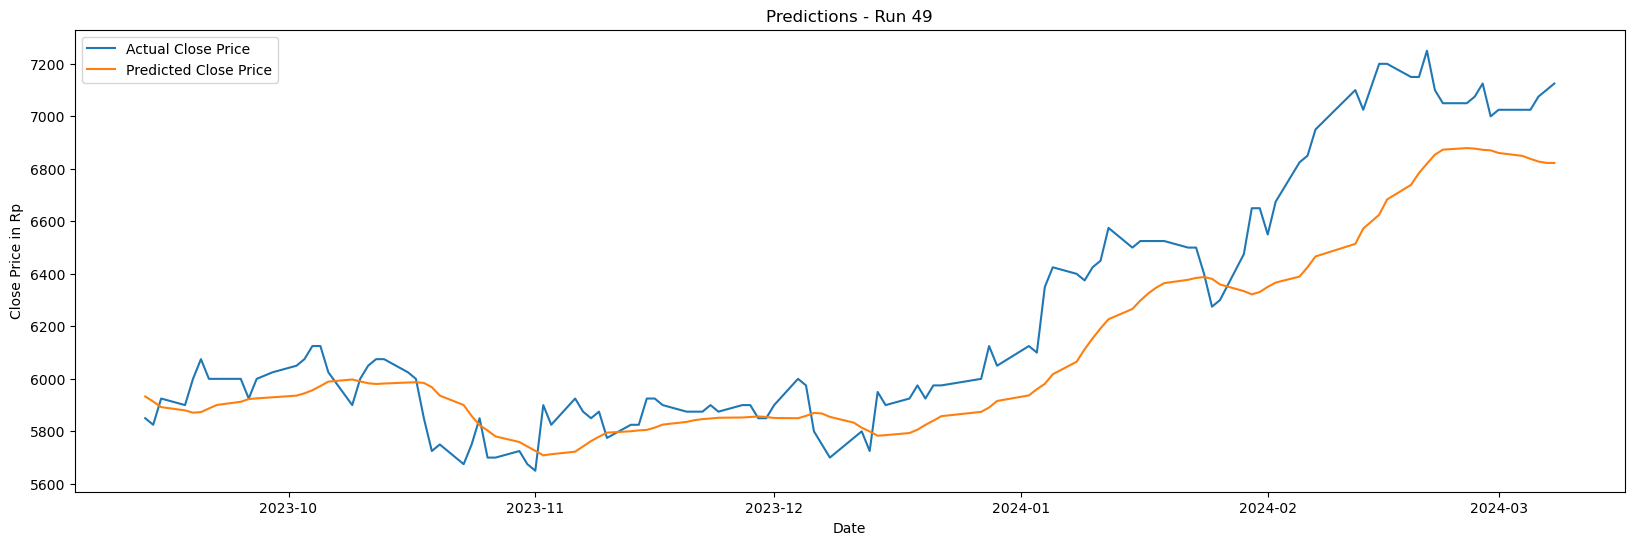

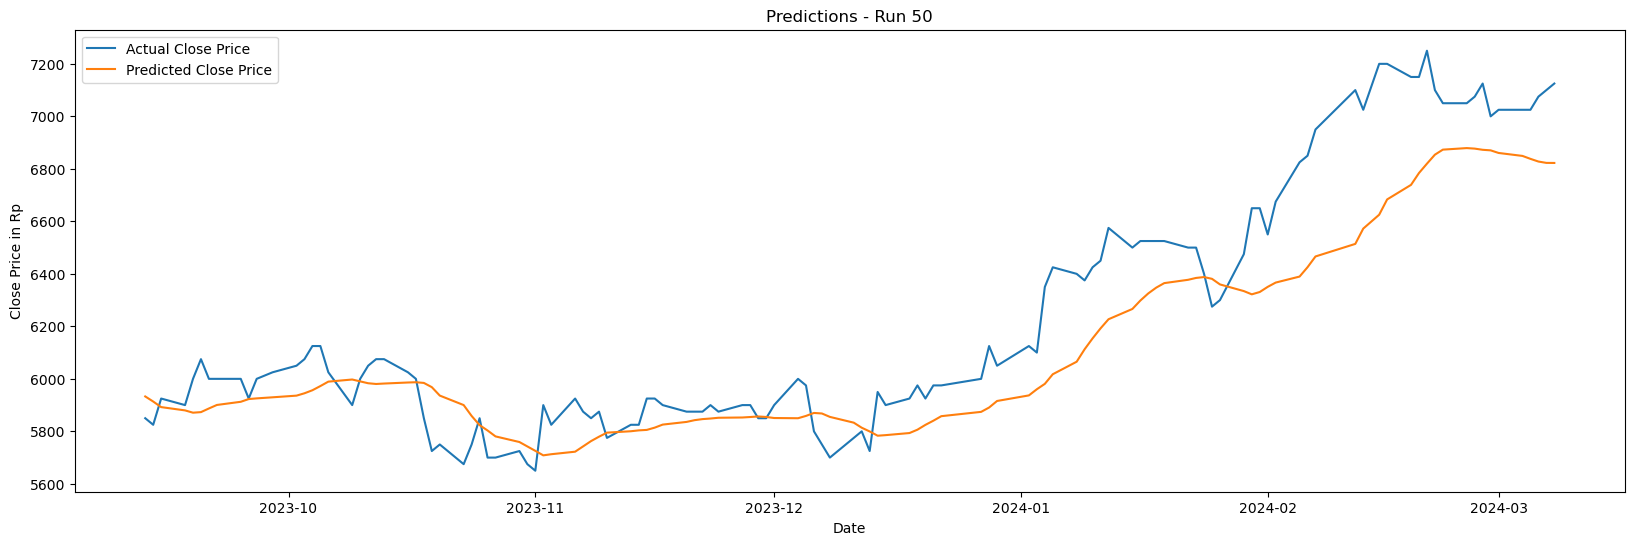

In [12]:
for i in range(50):
    # Plot predictions
    plt.figure(figsize=(20,6))
    plt.plot(data.index[training_data_len:], data['Close'][training_data_len:], label='Actual Close Price')
    plt.plot(data.index[training_data_len:], predictions, label='Predicted Close Price')
    plt.title(f'Predictions - Run {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Close Price in Rp')
    plt.legend()
    plt.show()

In [13]:
# Ambil kolom 'Average_Prediction'
average_prediction = results_df['Average_Prediction'].copy()

# Hapus 2 baris terakhir dari 'average_prediction'
average_prediction = average_prediction.iloc[:-2]

# Buat DataFrame baru dengan kolom 'Average_Prediction'
new_dataframe = pd.DataFrame(average_prediction, columns=['Average_Prediction'])

# Atur kolom 'Date' dari data sebagai indeks
new_dataframe.index = data.index[training_data_len:]

# Tambahkan kolom 'Actual' dari data asli
new_dataframe['Actual'] = data['Close'][training_data_len:]  

# Tampilkan DataFrame baru
print(new_dataframe)

            Average_Prediction  Actual
Date                                  
2023-09-13         5920.572607  5850.0
2023-09-14         5902.896240  5825.0
2023-09-15         5883.252148  5925.0
2023-09-18         5871.544219  5900.0
2023-09-19         5863.125000  6000.0
...                        ...     ...
2024-03-04         6837.779717  7025.0
2024-03-05         6828.395283  7025.0
2024-03-06         6819.602451  7075.0
2024-03-07         6815.256348  7100.0
2024-03-08         6815.246211  7125.0

[121 rows x 2 columns]


In [14]:
# Save DataFrame to CSV with header
new_dataframe.to_csv('BMRILSTMvsActualW100.csv', header=True)

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Fetch LSTM's Prediction (Average_Prediction) and the Actual data
predictions = new_dataframe['Average_Prediction']
actual = new_dataframe['Actual']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions))

# Calculate MAPE
mape = calculate_mape(actual, predictions)

# Print RMSE & MAPE
print('RMSE:', rmse)
print('MAPE:', mape)

RMSE: 217.41668856628903
MAPE: 2.671326002568936


/var/folders/dx/r9qzc02n76vb2zj4g6731w_r0000gn/T/ipykernel_40563/2582833144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


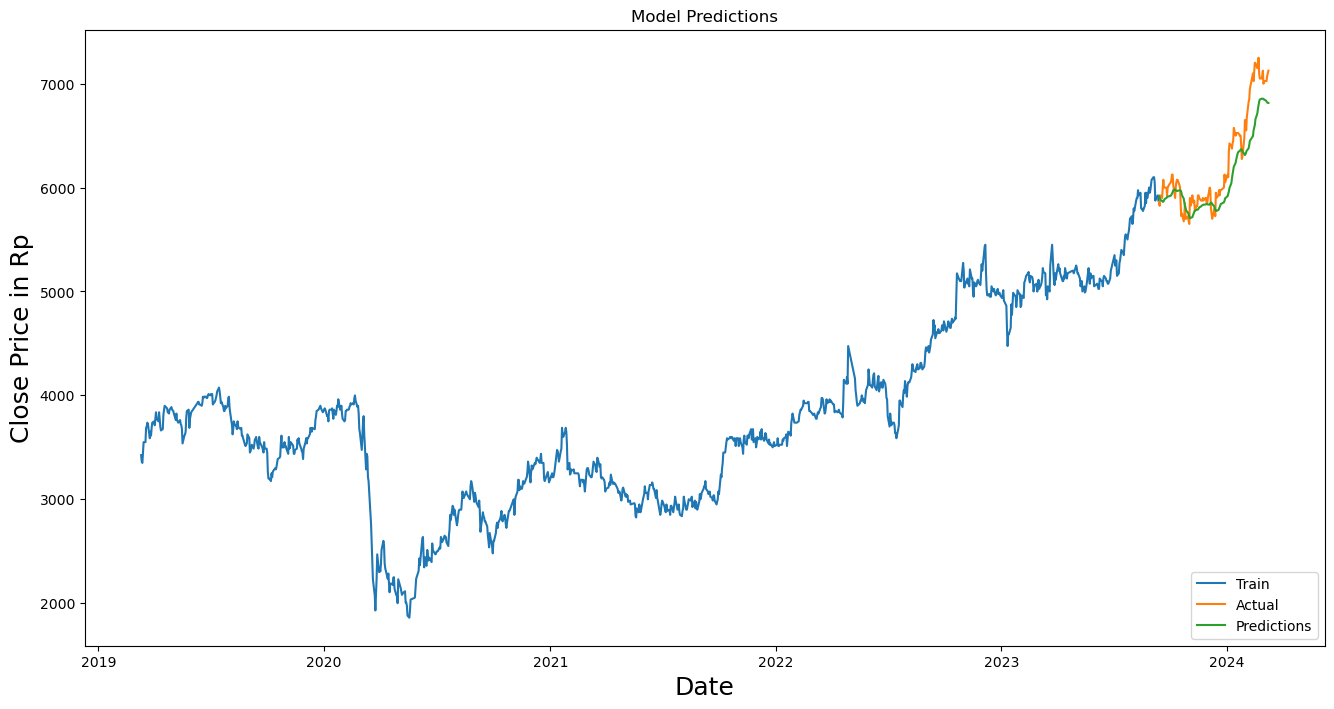

In [16]:
# Fetch testing and training data
train = data[:training_data_len]
valid = data[training_data_len:]

# Add 'Predictions'
valid['Predictions'] = predictions

# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual and prediction
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predictions')

# Add legend
plt.legend(loc='lower right')
plt.show()

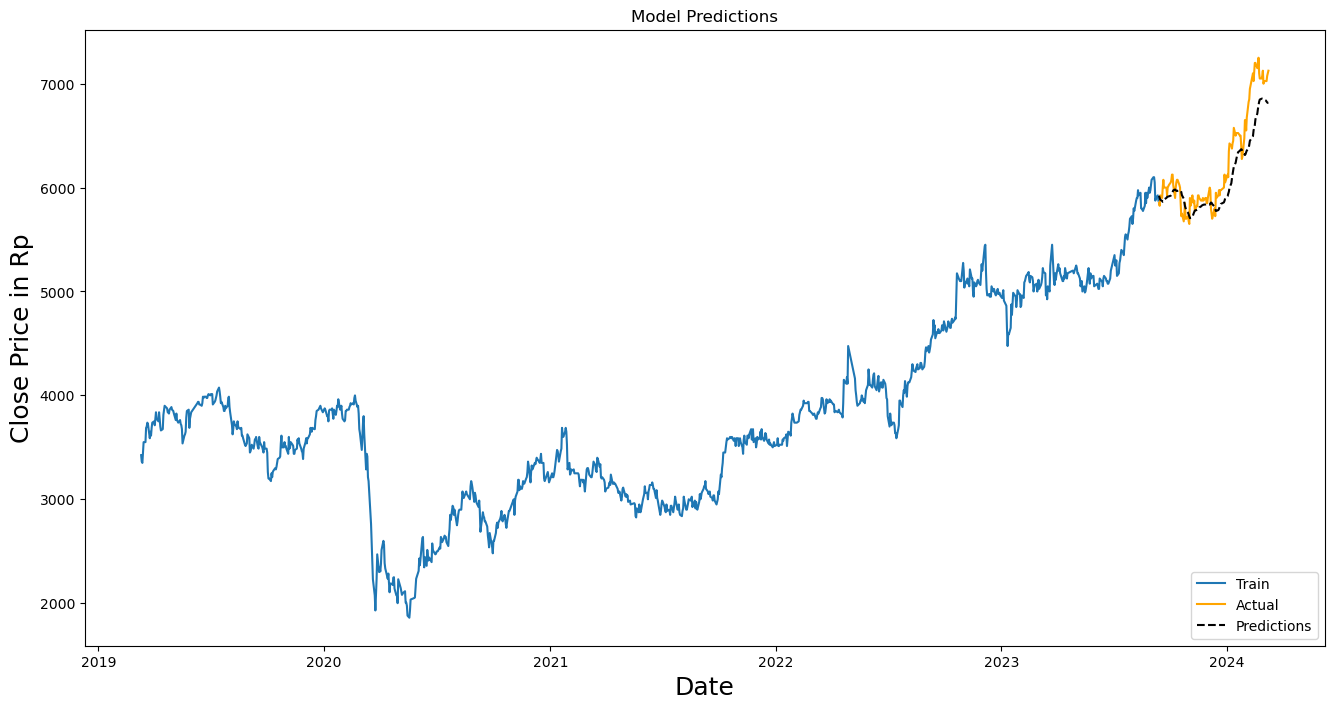

In [17]:
# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual data
plt.plot(valid.index, valid['Close'], label='Actual', linestyle='-', color='orange')

# Plot prediction data
plt.plot(valid.index, valid['Predictions'], label='Predictions', linestyle='--', color='black')

# Add legend
plt.legend(loc='lower right')
plt.show()